<a href="https://colab.research.google.com/github/joycedh/SWDance/blob/main/MyDataPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline for going from video playlist to dataset in HumanML3D format.
TODO
- Make a max. frames per sentence (how to clean this?).
- Visualise if it makes sense...
- Run motion representation script to build dataset
- Try to run model on it

## SetUp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title pip installs
# %%capture
# <-- try this to hide output from cell??

# # VIBE
!pip install git+https://github.com/pytube/pytube
!pip install tqdm yacs
!pip install smplx
!pip install trimesh pyrender progress filterpy
!pip install opencv-python llvmlite
!pip install git+https://github.com/mattloper/chumpy.git
# !pip install git+https://github.com/mkocabas/yolov3-pytorch.git
# !pip install git+https://github.com/mkocabas/multi-person-tracker.git
!pip install transforms3d
!pip install smplpytorch

# whisper
!pip install ffmpeg moviepy
# !pip install -U openai-whisper
!pip install -U stable-ts # this one has better timestamps

# !source scripts/prepare_data.sh

# for animation:
# !pip install matplotlib==3.3.4

# for emotion detection
!pip install --no-cache-dir transformers sentencepiece

# remember to set runtime type to GPU on colab!
# delete model when you're done!! ???
# del model

  Cloning https://github.com/pytube/pytube to /tmp/pip-req-build-daqjaea4
  Running command git clone --filter=blob:none --quiet https://github.com/pytube/pytube /tmp/pip-req-build-daqjaea4
  Resolved https://github.com/pytube/pytube to commit a32fff39058a6f7e5e59ecd06a7467b71197ce35
  Preparing metadata (setup.py) ... done
  Created wheel for pytube: filename=pytube-15.0.0-py3-none-any.whl size=57580 sha256=4781e953fef78a64c3c897d3d3ccdd5cb51ab44a8c7813093b93ff4545384a46
  Stored in directory: /tmp/pip-ephem-wheel-cache-gf7lah0r/wheels/b0/a9/7d/d3579227a695fdd15288c35657b3332ef0d71430ca7f685769
Successfully built pytube
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [3]:
#@title fix pytube bug
import os
import inspect
import pytube

package_path = os.path.dirname(inspect.getfile(pytube))
pytube_path = f'{package_path}/innertube.py'

with open(pytube_path, 'r', encoding='utf-8') as file:
    data = file.readlines()

print(data[222])
data[222] = data[222].replace('ANDROID_MUSIC', 'ANDROID')
print(data[222])

with open(pytube_path, 'w', encoding='utf-8') as file:
    file.writelines(data)

# test
with open(pytube_path, 'r', encoding='utf-8') as file:
    data = file.readlines()
print(data[222])


## for the other thingy

pytube_path = f'{package_path}/cipher.py'
with open(pytube_path, 'r', encoding='utf-8') as file:
    data = file.readlines()

print(data[410])
data[410] = data[410].replace('find_object_from_startpoint(raw_code, match.span()[1] - 1)', 'js')
print(data[410])

with open(pytube_path, 'w', encoding='utf-8') as file:
    file.writelines(data)

# test
with open(pytube_path, 'r', encoding='utf-8') as file:
    data = file.readlines()
print(data[410])

    def __init__(self, client='ANDROID_MUSIC', use_oauth=False, allow_cache=True):

    def __init__(self, client='ANDROID', use_oauth=False, allow_cache=True):

    def __init__(self, client='ANDROID', use_oauth=False, allow_cache=True):

    transform_plan_raw = find_object_from_startpoint(raw_code, match.span()[1] - 1)

    transform_plan_raw = js

    transform_plan_raw = js



# My Pipeline

### The thing

In [4]:
#@title imports etc
%cd /content/drive/MyDrive/THESIS
data_dir = '/content/drive/MyDrive/THESIS/data/SWDance'

import torch
import numpy as np
import pandas as pd
from pandas.io import json

import time
import joblib
import os, sys
import os.path as osp
import spacy
from tqdm import tqdm
import codecs as cs
import shutil

import cv2
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import whisper
import stable_whisper
import moviepy as mopy
from moviepy import editor
from pytube import Playlist, YouTube
# from multi_person_tracker import MPT
from torch.utils.data import DataLoader
from smplx import SMPL as SMPL_native
from scipy.signal import savgol_filter

print('Loading whisper model...')
WHISPER_MODEL = whisper.load_model("base")
WHISPER_MODEL = stable_whisper.load_model('base')

print('Loading models for caption augmentation...')
import gensim.downloader as gensim_api
from transformers import AutoTokenizer, AutoModelWithLMHead
GLOVE_MODEL = gensim_api.load("glove-wiki-gigaword-100")
EMOTION_TOKENIZER = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
EMOTION_MODEL = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

# WHISPER_MODEL = None
# GLOVE_MODEL = None
# EMOTION_TOKENIZER = None
# EMOTION_MODEL = None

print("Loading SMPL layer...") # for transform to smpl24
import transforms3d
from smplpytorch.display_utils import display_model
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
SMPL_LAYER = SMPL_Layer(center_idx=0,gender='neutral',model_root=osp.join(data_dir, 'smpl_models'))

# os.environ['PYOPENGL_PLATFORM'] = 'egl'
NLP = spacy.load('en_core_web_sm')
nltk.downloader.download('vader_lexicon')
# NLP = None

print('Loading VIBE model...')
sys.path.append('/content/drive/MyDrive/THESIS/VIBE')
from lib.models.vibe import VIBE_Demo
from lib.utils.demo_utils import download_ckpt, video_to_images
from lib.dataset.inference import Inference
from lib.models.smpl import SMPL_MODEL_DIR
# from lib.utils.smooth_pose import smooth_pose

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
VIBE_MODEL = VIBE_Demo(seqlen=16, n_layers=2, hidden_size=1024,
                                add_linear=True, use_residual=True).to(DEVICE)
pretrained_file = download_ckpt(use_3dpw=False)
ckpt = torch.load(pretrained_file)
print(f'Performance of pretrained VIBE model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
VIBE_MODEL.load_state_dict(ckpt, strict=False)
VIBE_MODEL.eval()
print(f'Loaded pretrained VIBE weights from \"{pretrained_file}\"')
# ckpt = None


# print("Loading multi person tracker for VIBE...")
# MY_MPT = MPT(device=DEVICE, batch_size=12,
#           display=False, detector_type='yolo',
#           output_format='dict', yolo_img_size=416)


# utils
def get_filename(file_idx):
  name_length = 6
  diff = name_length - len(str(file_idx))
  return diff*'0' + str(file_idx)

# from humanml3d notebook:
def swap_left_right(joints):

  assert len(joints.shape) == 3 and joints.shape[-1] == 3
  joints = joints.copy()
  joints[..., 0] *= -1

  right_chain = [2, 5, 8, 11, 14, 17, 19, 21]
  left_chain = [1, 4, 7, 10, 13, 16, 18, 20]

  tmp = joints[:, right_chain]
  joints[:, right_chain] = joints[:, left_chain]
  joints[:, left_chain] = tmp
  return joints



/content/drive/MyDrive/THESIS
Loading whisper model...


100%|███████████████████████████████████████| 139M/139M [00:03<00:00, 46.2MiB/s]


Loading models for caption augmentation...
[==================================================] 100.0% 128.1/128.1MB downloaded


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
  warnings.warn(



Loading SMPL layer...


  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Loading VIBE model...


  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.2MB/s]


=> loaded pretrained model from 'data/vibe_data/spin_model_checkpoint.pth.tar'
Performance of pretrained VIBE model on 3DPW: 56.56075477600098
Loaded pretrained VIBE weights from "data/vibe_data/vibe_model_wo_3dpw.pth.tar"


In [5]:
#@title Single Person Detector (yolov7)
# changed line 21 in utils/google_utils to `file = Path(str(file))` (in Drive the uppercase matters...)

from pathlib import Path
import torch.backends.cudnn as cudnn
from numpy import random

print('yolo imports...')
sys.path.append('/content/drive/MyDrive/THESIS/yolov7')
from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

def load_yolo_model(weights=['/content/drive/MyDrive/THESIS/yolov7/yolov7.pt'], img_size=640, trace=True, device=''):

  device = select_device(device)
  half = device.type != 'cpu'

  # Load model
  model = attempt_load(weights, map_location=device)  # load FP32 model
  if trace:
      model = TracedModel(model, device, img_size)
  if half:
      model.half()  # to FP16

  return model

YOLO_MODEL = load_yolo_model()

def SinglePersonDetector(
    model, source, img_size=640, conf_thres=0.25,
    iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=False,
    nosave=False, classes=None, agnostic_nms=False, augment=False,
    update=False, project='runs/detect', name='exp', exist_ok=False, save_bboxes=True):

  imgsz=img_size

  save_img = not nosave and not source.endswith('.txt')  # save inference images
  webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
      ('rtsp://', 'rtmp://', 'http://', 'https://'))

  # Directories
  save_dir = Path(increment_path(Path(project) / name, exist_ok=exist_ok))  # increment run
  (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

  # Initialize
  set_logging()
  device = select_device(device)
  half = device.type != 'cpu'

  # Model attributes
  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(imgsz, s=stride)  # check img_size

  # Second-stage classifier
  classify = False
  if classify:
      modelc = load_classifier(name='resnet101', n=2)  # initialize
      modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

  # Set Dataloader
  vid_path, vid_writer = None, None
  if webcam:
      view_img = check_imshow()
      cudnn.benchmark = True  # set True to speed up constant image size inference
      dataset = LoadStreams(source, img_size=imgsz, stride=stride)
  else:
      dataset = LoadImages(source, img_size=imgsz, stride=stride)

  # Get names and colors
  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

  # Run inference
  if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
  old_img_w = old_img_h = imgsz
  old_img_b = 1

  t0 = time.time()
  person_tracked = False
  bbox_info = {'frames':[], 'bbox': []}
  for path, img, im0s, vid_cap in tqdm(dataset):
      img = torch.from_numpy(img).to(device)
      img = img.half() if half else img.float()  # uint8 to fp16/32
      img /= 255.0  # 0 - 255 to 0.0 - 1.0
      if img.ndimension() == 3:
          img = img.unsqueeze(0)

      # Warmup
      if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
          old_img_b = img.shape[0]
          old_img_h = img.shape[2]
          old_img_w = img.shape[3]
          for i in range(3):
              model(img, augment=augment)[0]

      # Inference
      t1 = time_synchronized()
      with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
          pred = model(img, augment=augment)[0]
      t2 = time_synchronized()

      # Apply NMS
      pred = non_max_suppression(pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
      t3 = time_synchronized()

      # Apply Classifier
      if classify:
          pred = apply_classifier(pred, modelc, img, im0s)

      # Process detections
      for i, det in enumerate(pred):  # detections per image
          if webcam:  # batch_size >= 1
              p = Path(path[i])
              s, im0, frame = '%g: ' % i, im0s[i].copy(), dataset.count
          else:
              p = Path(path)
              s, im0, frame = '', im0s, getattr(dataset, 'frame', int(p.stem)-1)

          save_path = str(save_dir / p.name)  # img.jpg
          txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
          gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh

          if len(det):
              # Rescale boxes from img_size to im0 size
              det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

              # Print results
              for c in det[:, -1].unique():
                  n = (det[:, -1] == c).sum()  # detections per class
                  s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

              # Results
              biggest_bbox = 0
              xyxy_main = det[-1][:4]

              for *xyxy, conf, cls in reversed(det):  # check all boxes & get main person out
                if cls == 0:  # get persons (idx for person = 0)
                  person_tracked = True

                  # MPT style
                  xyxy = [d.cpu() for d in xyxy]
                  w, h = xyxy[2] - xyxy[0], xyxy[3] - xyxy[1]
                  c_x, c_y = xyxy[0] + w/2, xyxy[1] + h/2

                  if float(w*h) > biggest_bbox:
                    biggest_bbox = float(w*h)
                    w = h = np.where(w / h > 1, w, h)
                    bbox_MPT_main = np.array([c_x, c_y, w, h])
                    xyxy_main = xyxy

              if person_tracked:   # only write if a person has been tracked...
                bbox_info['frames'] += [frame]
                bbox_info['bbox'] += [bbox_MPT_main]

                if save_txt:  # Write to file
                    line = (cls, *bbox_MPT_main, conf) if save_conf else (cls, *bbox_MPT_main)  # label format
                    with open(txt_path + '.txt', 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')

                if save_img or view_img:  # Add bbox to image
                    label = f'{names[int(cls)]} {conf:.2f}'
                    plot_one_box(xyxy_main, im0, label=label, color=colors[int(cls)], line_thickness=1)

          # Print time (inference + NMS)
          # print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

          # Stream results
          if view_img and person_tracked:
              cv2.imshow(str(p), im0)
              cv2.waitKey(1)  # 1 millisecond

          # Save results (image with detections)
          if save_img and person_tracked:
              if dataset.mode == 'image':
                  cv2.imwrite(save_path, im0)
                  print(f" The image with the result is saved in: {save_path}")
              else:  # 'video' or 'stream'
                  if vid_path != save_path:  # new video
                      vid_path = save_path
                      if isinstance(vid_writer, cv2.VideoWriter):
                          vid_writer.release()  # release previous video writer
                      if vid_cap:  # video
                          fps = vid_cap.get(cv2.CAP_PROP_FPS)
                          w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                          h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                      else:  # stream
                          fps, w, h = 30, im0.shape[1], im0.shape[0]
                          save_path += '.mp4'
                      vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                  vid_writer.write(im0)

  if save_txt or save_img and person_tracked:
      s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
      print(f"Results saved to {save_dir}{s}")

  if not person_tracked:
    shutil.rmtree(save_dir)
    print("No person was tracked so no output :(")

  print(f'Done. ({time.time() - t0:.3f}s)')
  return bbox_info

yolo imports...
Fusing layers... 


  if param.grad is not None:



RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [6]:
#@title THE NEW DP

VIDEO_SAVEPATH = '/content/drive/MyDrive/THESIS/data/SWDance/videos'

class DataProcessor:

  def __init__(self, data_dir, device=None):
    ''' In video_path, insert either a directory where your videos are stored,
        or otherwise, a link to a single youtube video or a youtube playlist
        link '''
    self.data_dir = data_dir
    self.videos_df = pd.read_csv(osp.join(self.data_dir, 'video_files.csv'))

    self.device = DEVICE if device is None else device

    self.whisper_model = WHISPER_MODEL
    self.glove_model = GLOVE_MODEL
    self.emotion_tokenizer = EMOTION_TOKENIZER
    self.emotion_model = EMOTION_MODEL
    self.vibe_model = VIBE_MODEL
    # self.MPT = MY_MPT
    self.SMPL_layer = SMPL_LAYER
    self.nlp = NLP

    self.min_frames = 25
    self.vibe_batch_size = 128
    self.tracker_batch_size = 12
    self.yolo_img_size = 416
    self.display = False
    self.render = False
    self.bbox_scale = 1.1
    self.smooth_pose = False

  def download_yt_video(self, url, video_idx):

    if osp.isfile(f'{VIDEO_SAVEPATH}/{video_idx}.mp4'):
      print(f'yt video exists: {VIDEO_SAVEPATH}/{video_idx}.mp4')
      return f'{VIDEO_SAVEPATH}/{video_idx}.mp4', self.videos_df.loc[video_idx, ('fps')]

    yt = YouTube(url)
    stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    # stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').first()
    print(f'video resolution= {stream.resolution}')
    video_fps = stream.fps
    video_file = stream.download(output_path=f'{VIDEO_SAVEPATH}', filename=f'{video_idx}.mp4')

    if video_file is None:
      exit('Youtube url is not valid!')
    print(f'YouTube Video has been downloaded to {video_file}...')
    return video_file, video_fps

  def get_whisper_captions(self, video_file):
    video_idx = osp.basename(video_file).replace('.mp4', '')
    audio_file = osp.join('/tmp', f'{video_idx}.wav')
    caps_file = osp.join(osp.join(self.data_dir, 'caption_output'),
                           f"{video_idx}.pkl")

    if osp.isfile(audio_file):
      print(f'audio video exists: {audio_file}')
    else:
      clip = mopy.editor.VideoFileClip(video_file)
      clip.audio.write_audiofile(audio_file, codec='pcm_s16le')

    if osp.isfile(caps_file):
      print(f'caps file exists: {caps_file}')
      return joblib.load(caps_file)
    else:
      # captions = self.whisper_model.transcribe(audio_file) # normal whisper model
      captions = self.whisper_model.transcribe(audio_file, word_timestamps=False).to_dict()
      joblib.dump(captions, caps_file)

    del audio_file
    return captions

  def process_captions(self, captions, video_fps):
    # function inspired by HumanML3D github

    processed_captions = []

    for caption in captions['segments']:
      text = caption['text']
      text = self.augment_captions(text)
      doc = self.nlp(text)

      if doc == "" or doc == " ":
        # save empty as X? -> https://spacy.io/api/token#attributes
        tokens = ' /X'

      else:
        word_list, pos_list = [], []
        for token in doc:
          word = token.text
          if not word.isalpha():
            continue
          if (token.pos_ == 'NOUN' or token.pos_ == 'VERB') and (word != 'left'):
            word_list.append(token.lemma_)
          else:
            word_list.append(word)
          pos_list.append(token.pos_)
        tokens = ' '.join([f'{word_list[i]}/{pos_list[i]}' for i in range(len(word_list))])

      # timestamp (s) to frame_count
      start = caption['start']
      end = caption['end']

      caption_info = {"text": caption["text"], "tokens": tokens, "start": start, "end": end}
      processed_captions.append(caption_info)

    return processed_captions

  def augment_captions(self, caption, emotions=True, similar_words=True):

    sia = SentimentIntensityAnalyzer()
    cap_polarity = sia.polarity_scores(caption)['compound']

    if emotions:
      input_ids = self.emotion_tokenizer.encode(caption, return_tensors='pt')
      emotion_output = self.emotion_model.generate(input_ids=input_ids, max_length=20)
      emotion = [self.emotion_tokenizer.decode(ids, skip_special_tokens=True) for ids in emotion_output][0]
    else:
      emotion = ""

    if similar_words:   # TODO: only simwords for the emotion word??
      similar_words = self.glove_model.most_similar(emotion) # could premake this bc it has only 5 emotions
      similar_words = [w[0] for w in similar_words]
      for word in similar_words:
        word_polarity = sia.polarity_scores(word)['compound']
        if not cap_polarity - 0.5 <= word_polarity <= cap_polarity + 0.5:
          similar_words.remove(word)

      similar_words = " ".join(similar_words[:5])
    else:
      similar_words = ""

    return f'{caption} {emotion} {similar_words}'

  def get_vibe_poses(self, video_file):
    # inspired by VIBE github code but modified.
    # need to download VIBE in subfolder to be able to run this.

    video_idx = osp.basename(video_file).replace('.mp4', '')
    output_file = osp.join(osp.join(self.data_dir, 'vibe_output'),
                           f"{video_idx}.pkl")

    if osp.isfile(output_file):
      print(f'VIBE file exists: {output_file}')
      output_dict = joblib.load(output_file)
      return output_dict

    if osp.isdir(f'/tmp/{video_idx}_mp4'):
      image_folder = f'/tmp/{video_idx}_mp4'
      img_files = [i for i in os.listdir(image_folder)]
      num_frames = len(img_files)
      test_img = cv2.imread(f'{image_folder}/{img_files[0]}')
      img_shape = test_img.shape
    else:
      image_folder, num_frames, img_shape = video_to_images(video_file, return_info=True)

    print(f'Video {video_idx}, number of frames: {num_frames}')
    orig_height, orig_width = img_shape[:2]
    total_time = time.time()

    print('Tracking pose...')
    tracking_results = SinglePersonDetector(
        YOLO_MODEL, source=image_folder,
        conf_thres=0.85, save_txt=False,
        save_conf=False, nosave=True,
        project='data/SWDance/videos',
    )

    bboxes = np.array(tracking_results['bbox'])
    frames = np.array(tracking_results['frames'])

    print(f'Running VIBE...')
    dataset = Inference(
        image_folder=image_folder,
        frames=frames,
        bboxes=bboxes,
        joints2d=None,
        scale=self.bbox_scale,
    )

    dataloader = DataLoader(dataset, batch_size=self.vibe_batch_size, num_workers=4)

    with torch.no_grad():
      pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d = [], [], [], [], []

      for batch in tqdm(dataloader):
        try:
          batch = batch.unsqueeze(0)
          batch = batch.to(self.device)
          batch_size, seqlen = batch.shape[:2]

          output = dp.vibe_model(batch)[-1]

          pred_cam.append(output['theta'][:, :, :3].reshape(batch_size * seqlen, -1))
          pred_verts.append(output['verts'].reshape(batch_size * seqlen, -1, 3))
          pred_pose.append(output['theta'][:,:,3:75].reshape(batch_size * seqlen, -1))
          pred_betas.append(output['theta'][:, :,75:].reshape(batch_size * seqlen, -1))
          pred_joints3d.append(output['kp_3d'].reshape(batch_size * seqlen, -1, 3))

        except Exception as e:
          print("Error:", e)

        del batch

    print('Transform pose to SMPL24 ...')
    smpl24_joints = self.transform_pose_smpl24(torch.cat(pred_pose, dim=0).cpu(),
                                               torch.cat(pred_betas, dim=0).cpu())
    print('Post process pose and smooth...')
    smpl24_joints_smooth = self.post_process_pose(dataset.bboxes, smpl24_joints)

    output_dict = {
            'pred_cam': torch.cat(pred_cam, dim=0).cpu().numpy(),
            'verts': torch.cat(pred_verts, dim=0).cpu().numpy(),
            'pose': torch.cat(pred_pose, dim=0).cpu().numpy(),
            'betas': torch.cat(pred_betas, dim=0).cpu().numpy(),
            'joints3d': torch.cat(pred_joints3d, dim=0).cpu().numpy(),
            'bboxes': dataset.bboxes,
            'frame_ids': dataset.frames,
            'smpl24_joints': smpl24_joints,
            'smpl24_joints_smooth': smpl24_joints_smooth
            }

    total_time = time.time() - total_time
    print(f'Total time: {total_time:.2f}s for {num_frames} frames.')

    print(f'Saving output results to \"{output_file}\".')
    joblib.dump(output_dict, output_file)
    # shutil.rmtree(image_folder)   # deletes the images
    return output_dict

  def transform_pose_smpl24(self, pose, betas):
    # get smpl24
    verts, smpl24_joints = self.SMPL_layer(pose, th_betas=betas)

    # flip upside down (VIBE output = upside down)
    R = transforms3d.euler.axangle2mat([1, 0, 0], -np.pi)
    smpl24_rotated = np.dot(smpl24_joints, R)

    return smpl24_rotated

  def align_captions_poses(self, captions, pose_dict, index_df, video_idx):

    print(f'Aligning poses and caps for video {video_idx}...')
    file_idx = 0 if index_df.empty else index_df['file_idx'].iloc[-1]+1
    curr_timestamp = 0

    for caption in captions:
      if caption['start'] > curr_timestamp:
        # frames with NO captions
        file_idx, index_df = self.save_pose(
            file_idx, video_idx, pose_dict, index_df,
            start=curr_timestamp,
            end=caption['start'],
            caption=False)

      # frames WITH captions
      file_idx, index_df = self.save_pose(
          file_idx, video_idx, pose_dict, index_df,
          start=caption['start'],
          end=caption['end'],
          caption=caption)
      curr_timestamp = caption['end']

    return index_df

  def fill_missing_frames(self, joints):

    consec_missing = []   # TODO: fill up with in-betweening??

    for i in range(len(joints)):
      if np.isnan(joints[i]).all():
        consec_missing += [i]
        if len(consec_missing) > 10:
          print('more than 10 are missing consecutively ', i)
        joints[i] = joints[i-1]  # fill with prev joints
      else:
        consec_missing = []

    return joints

  def save_pose(self, file_idx, video_idx, pose_dict, index_df, start, end, caption=True):
    filename = get_filename(file_idx)
    video_fps = self.videos_df.loc[video_idx, ('fps')]
    frame_ids = [i for i in range(round(start*video_fps), round(end*video_fps)+1)]
    joints = []

    for frame_id in frame_ids:
      idx = np.where(pose_dict['frame_ids'] == frame_id)[0] # first appearance
      try:
        if idx.size > 0:
          joints += [pose_dict['smpl24_joints_smooth'][idx[0]]]
        else:
          joints += [np.full([24, 3], np.nan)]

    # for frame_id in frame_ids:
    #   idx = pose_dict['frame_ids'].index(frame_id) if frame_id in pose_dict['frame_ids'] else -1
    #   try:
    #     if idx > 0:
    #       joints += [pose_dict['smpl24_joints_smooth'][idx]]
    #     else:
    #       joints += [np.full([24, 3], np.nan)]

      except Exception as e:
        print(f"not working for joints idx {idx}, {type(joints)} to append {type(pose_dict['smpl24_joints_smooth'][idx[0]])} \n {e}")

    if all(np.isnan(j).all() for j in joints):
      print(f'no joints for video {video_idx} at {start} to {end}')
      return file_idx, index_df

    # remove the Nones at the beginning and end of the list
    while np.isnan(joints[-1]).all():
      end -= round(1/video_fps, 2)
      del joints[-1]

    while np.isnan(joints[0]).all():
      start += round(1/video_fps, 2)
      del joints[0]

    if len(joints) < self.min_frames:
      print(f'not enough joints for video {video_idx} at {start} to {end}')
      return file_idx, index_df

    joints = self.fill_missing_frames(joints)
    joints = np.stack(joints, axis=0)

    for side in ['', 'M']: # mirror pose
      if side == 'M':
        joints = swap_left_right(joints)

      np.save(osp.join(osp.join(self.data_dir, 'joints'), f'{side}{filename}.npy'), joints)
      df_row = {'file_idx': file_idx,
                'video_idx': video_idx,               # which video it belongs to
                'start_frame': round(start*video_fps),
                'end_frame': round(end*video_fps),
                'start_time': start,
                'end_time': end,
                'new_name': f'{side}{filename}.npy',  # named for humanml3d
                'fps': video_fps,
                'caption': "" if not caption else caption["text"],
                'no_frames': len(joints)}
      index_df = pd.concat([index_df, pd.DataFrame([df_row])], ignore_index=True)

      if caption:
        with open(osp.join(osp.join(self.data_dir, 'texts'), f'{side}{filename}.txt'), 'w') as f:
            f.write(f'{caption["text"]}#{caption["tokens"]}#0.0#0.0\n')
      else:
        with open(osp.join(osp.join(self.data_dir, 'texts'),
                          f'{side}{filename}.txt'), 'w') as f:
              f.write(f' # /X#0.0#0.0\n')

    file_idx += 1

    return file_idx, index_df

  def post_process_pose(self, bboxes, joints):
    # first, get x,y movement from bboxes
    # normalise bboxes between 0 & 1
    bbox_diff = np.max(bboxes, axis=0) - np.min(bboxes, axis=0)
    bbox_norm = (bboxes-np.min(bboxes, axis=0))/bbox_diff

    origin = bbox_norm[0]
    delta_bbox = bbox_norm - origin # change from every bbox from origin

    for i, joint in enumerate(joints):
      joints[i, :, 0] = joints[i, :, 0] - delta_bbox[i, 0]/2 # not all movement
      joints[i, :, 1] = joints[i, :, 1] - delta_bbox[i, 1]/2

    # then, translate pose to be standing on the floor
    # lowest y coordinate of feet joints (= 10 & 11)
    lowest = min(np.min(joints[:, 10, 1]), np.min(joints[:, 11, 1]))
    diff = 0 - lowest
    joints[:, :, 1] = joints[:, :, 1] + diff

    # finally, smooth pose with smoothing filter
    joints = savgol_filter(joints, window_length=12, polyorder=3, axis=0)

    return joints

  def run(self):
    try:
      index_df = pd.read_csv(osp.join(self.data_dir, 'index.csv'))
    except:
      index_df = pd.DataFrame()

    for i, video in self.videos_df.iterrows():
      print(f'Processing video {i}...')

      video_file = video['video_file']
      if video['processed'] == True:
        video_fps = video['fps']
        print(f'video {i} is already processed')
        continue
      elif any(yt in video_file for yt in ["youtube", "youtu.be"]):
        try:
          video_file, video_fps = self.download_yt_video(video_file, i)
        except Exception as e:
          print(f'Could not download video {i}, {e}')
          continue

      vibe_output = self.get_vibe_poses(video_file)

      caps = self.get_whisper_captions(video_file)
      processed_caps = self.process_captions(caps, video_fps)

      index_df = self.align_captions_poses(processed_caps, vibe_output, index_df, i)
      self.videos_df.loc[i, ('processed')] = True
      self.videos_df.loc[i, ('fps')] = video_fps

      # update dfs after each video
      index_df.to_csv(osp.join(self.data_dir, 'index.csv'), index=False)
      self.videos_df.to_csv(osp.join(self.data_dir,'video_files.csv'), index=False)

      vibe_output = caps = processed_caps = None # does this clear RAM?

    return index_df

### Some tests

In [ ]:
# reset things
!rm /content/drive/MyDrive/THESIS/data/SWDance/index.csv
!touch /content/drive/MyDrive/THESIS/data/SWDance/index.csv

videos_df = pd.read_csv('/content/drive/MyDrive/THESIS/data/SWDance/video_files.csv')
videos_df.loc[1, ('processed')] = False  # do this for every video maybe??
videos_df.to_csv(osp.join(data_dir,'video_files.csv'), index=False)
print(videos_df.head())

# !rm /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/0.pkl
# !rm /content/drive/MyDrive/THESIS/data/SWDance/caption_output/0.pkl
# !rm /tmp/0.mp4
# !rm /content/drive/MyDrive/THESIS/data/SWDance/videos/0.mp4
# !rm -r /tmp/0_mp4
!rm /content/drive/MyDrive/THESIS/data/SWDance/joints/*

                                    video_file  processed  fps
0  https://www.youtube.com/watch?v=fSHjGPWmkb8      False   20
1  https://www.youtube.com/watch?v=AxFyPYnl0cU      False   20
2  https://www.youtube.com/watch?v=xwff7dvjNv0      False   20
3  https://www.youtube.com/watch?v=bf8NCSH-PJ8      False   20
4  https://www.youtube.com/watch?v=Z8Xmgd6V398      False   20
rm: cannot remove '/content/drive/MyDrive/THESIS/data/SWDance/joints/*': No such file or directory


In [20]:
dp = DataProcessor(data_dir)

In [21]:
index_df = dp.run()

Processing video 0...
video 0 is already processed
Processing video 1...
video 1 is already processed
Processing video 2...
yt video exists: /content/drive/MyDrive/THESIS/data/SWDance/videos/2.mp4
VIBE file exists: /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/2.pkl
audio video exists: /tmp/2.wav
caps file exists: /content/drive/MyDrive/THESIS/data/SWDance/caption_output/2.pkl
Aligning poses and caps for video 2...
no joints for video 2 at 0 to 0.08
no joints for video 2 at 0.08 to 0.9
no joints for video 2 at 0.9 to 2.26
no joints for video 2 at 2.26 to 3.06
no joints for video 2 at 3.06 to 4.26
no joints for video 2 at 4.26 to 4.92
no joints for video 2 at 4.92 to 6.3
no joints for video 2 at 6.3 to 7.32
no joints for video 2 at 7.32 to 14.8
no joints for video 2 at 14.8 to 17.6
no joints for video 2 at 17.6 to 21.16
not enough joints for video 2 at 54.0 to 54.18
not enough joints for video 2 at 54.18 to 55.0
not enough joints for video 2 at 61.08 to 62.0
not enough joints f

MoviePy - Done.
caps file exists: /content/drive/MyDrive/THESIS/data/SWDance/caption_output/3.pkl
Aligning poses and caps for video 3...
no joints for video 3 at 0 to 0.24
no joints for video 3 at 0.24 to 4.64
no joints for video 3 at 4.64 to 4.84
no joints for video 3 at 4.84 to 8.06
not enough joints for video 3 at 21.76 to 22.82
not enough joints for video 3 at 40.2 to 41.04
not enough joints for video 3 at 46.16 to 46.8
not enough joints for video 3 at 70.94 to 71.04
not enough joints for video 3 at 77.72 to 78.36
not enough joints for video 3 at 84.8 to 84.96
not enough joints for video 3 at 106.12 to 106.28
more than 10 are missing consecutively  73
more than 10 are missing consecutively  74
more than 10 are missing consecutively  17
more than 10 are missing consecutively  18
more than 10 are missing consecutively  19
more than 10 are missing consecutively  20
more than 10 are missing consecutively  21
more than 10 are missing consecutively  22
more than 10 are missing consecutiv

MoviePy - Done.


  0%|          | 0/151.56 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 151.56/151.56 [00:05<00:00, 29.39sec/s]


Aligning poses and caps for video 4...
more than 10 are missing consecutively  42
more than 10 are missing consecutively  43
more than 10 are missing consecutively  44
more than 10 are missing consecutively  45
more than 10 are missing consecutively  46
more than 10 are missing consecutively  47
more than 10 are missing consecutively  48
more than 10 are missing consecutively  49
more than 10 are missing consecutively  50
more than 10 are missing consecutively  51
more than 10 are missing consecutively  52
more than 10 are missing consecutively  53
more than 10 are missing consecutively  54
more than 10 are missing consecutively  55
more than 10 are missing consecutively  56
more than 10 are missing consecutively  57
more than 10 are missing consecutively  58
more than 10 are missing consecutively  59
more than 10 are missing consecutively  60
more than 10 are missing consecutively  61
more than 10 are missing consecutively  62
more than 10 are missing consecutively  63
more than 10 ar

MoviePy - Done.


  0%|          | 0/171.25 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 171.25/171.25 [00:03<00:00, 48.60sec/s]


Aligning poses and caps for video 5...
not enough joints for video 5 at 1.2000000000000004 to 1.6
not enough joints for video 5 at 34.72 to 35.04
not enough joints for video 5 at 68.32 to 69.2
not enough joints for video 5 at 71.04 to 72.16
not enough joints for video 5 at 76.32 to 76.96
not enough joints for video 5 at 78.96 to 79.92
not enough joints for video 5 at 82.32 to 83.12
not enough joints for video 5 at 131.12 to 132.26999999999998
not enough joints for video 5 at 154.88 to 155.76
not enough joints for video 5 at 159.28 to 160.16
not enough joints for video 5 at 163.44 to 164.48
Processing video 6...
yt video exists: /content/drive/MyDrive/THESIS/data/SWDance/videos/6.mp4
VIBE file exists: /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/6.pkl
MoviePy - Writing audio in /tmp/6.wav


MoviePy - Done.


  0%|          | 0/138.25 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 138.25/138.25 [00:04<00:00, 34.23sec/s]


Aligning poses and caps for video 6...
not enough joints for video 6 at 0 to 0.5
not enough joints for video 6 at 32.0 to 32.12
not enough joints for video 6 at 39.52 to 39.84
not enough joints for video 6 at 46.12 to 46.44
not enough joints for video 6 at 49.52 to 50.52
more than 10 are missing consecutively  25
more than 10 are missing consecutively  26
more than 10 are missing consecutively  27
more than 10 are missing consecutively  28
more than 10 are missing consecutively  29
not enough joints for video 6 at 76.6 to 77.76
not enough joints for video 6 at 83.12 to 84.24
not enough joints for video 6 at 93.44 to 94.4
not enough joints for video 6 at 101.36 to 102.16
not enough joints for video 6 at 114.12 to 114.68
not enough joints for video 6 at 116.88 to 117.05000000000017
more than 10 are missing consecutively  17
more than 10 are missing consecutively  18
more than 10 are missing consecutively  19
more than 10 are missing consecutively  20
more than 10 are missing consecutivel

MoviePy - Done.


  0%|          | 0/238.84 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 238.84/238.84 [00:06<00:00, 38.44sec/s]


Aligning poses and caps for video 7...
more than 10 are missing consecutively  79
more than 10 are missing consecutively  80
more than 10 are missing consecutively  81
more than 10 are missing consecutively  82
more than 10 are missing consecutively  83
more than 10 are missing consecutively  84
more than 10 are missing consecutively  85
more than 10 are missing consecutively  86
more than 10 are missing consecutively  87
more than 10 are missing consecutively  88
more than 10 are missing consecutively  89
more than 10 are missing consecutively  90
not enough joints for video 7 at 59.68 to 60.0
not enough joints for video 7 at 80.16 to 81.16
not enough joints for video 7 at 88.72 to 89.72
not enough joints for video 7 at 89.72 to 90.0
not enough joints for video 7 at 95.16 to 95.22
not enough joints for video 7 at 165.32 to 165.5
not enough joints for video 7 at 174.44 to 175.44
not enough joints for video 7 at 175.44 to 176.6
not enough joints for video 7 at 181.4 to 181.94
Processing

MoviePy - Done.


  0%|          | 0/201.97 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 201.97/201.97 [00:03<00:00, 63.37sec/s]


Aligning poses and caps for video 8...
no joints for video 8 at 0 to 3.72
more than 10 are missing consecutively  63
more than 10 are missing consecutively  64
more than 10 are missing consecutively  65
more than 10 are missing consecutively  66
more than 10 are missing consecutively  67
more than 10 are missing consecutively  68
more than 10 are missing consecutively  69
more than 10 are missing consecutively  70
more than 10 are missing consecutively  71
more than 10 are missing consecutively  72
more than 10 are missing consecutively  73
more than 10 are missing consecutively  74
more than 10 are missing consecutively  75
more than 10 are missing consecutively  76
more than 10 are missing consecutively  77
more than 10 are missing consecutively  78
more than 10 are missing consecutively  79
more than 10 are missing consecutively  80
more than 10 are missing consecutively  81
more than 10 are missing consecutively  82
more than 10 are missing consecutively  83
more than 10 are missin

MoviePy - Done.


  0%|          | 0/180.28 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 180.28/180.28 [00:07<00:00, 23.60sec/s]


Aligning poses and caps for video 9...
no joints for video 9 at 0.0 to 1.6
no joints for video 9 at 1.6 to 8.4
no joints for video 9 at 8.4 to 12.96
no joints for video 9 at 12.96 to 14.08
not enough joints for video 9 at 22.16 to 22.18
more than 10 are missing consecutively  63
more than 10 are missing consecutively  64
more than 10 are missing consecutively  65
more than 10 are missing consecutively  66
more than 10 are missing consecutively  67
more than 10 are missing consecutively  68
more than 10 are missing consecutively  69
more than 10 are missing consecutively  70
more than 10 are missing consecutively  71
more than 10 are missing consecutively  72
more than 10 are missing consecutively  73
more than 10 are missing consecutively  74
more than 10 are missing consecutively  75
more than 10 are missing consecutively  76
more than 10 are missing consecutively  77
more than 10 are missing consecutively  78
more than 10 are missing consecutively  79
more than 10 are missing consecu

MoviePy - Done.


  0%|          | 0/136.49 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 136.49/136.49 [00:03<00:00, 34.85sec/s]


NotImplementedError: ignored

In [8]:
index_df = dp.run()
# vibe_output = dp.get_vibe_poses('/content/drive/MyDrive/THESIS/data/SWDance/videos/0.mp4')

Processing video 0...
video 0 is already processed
Processing video 1...
video 1 is already processed
Processing video 2...
yt video exists: /content/drive/MyDrive/THESIS/data/SWDance/videos/2.mp4
VIBE file exists: /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/2.pkl
Processing video 3...
yt video exists: /content/drive/MyDrive/THESIS/data/SWDance/videos/3.mp4
VIBE file exists: /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/3.pkl
Processing video 4...
yt video exists: /content/drive/MyDrive/THESIS/data/SWDance/videos/4.mp4
VIBE file exists: /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/4.pkl
Processing video 5...
yt video exists: /content/drive/MyDrive/THESIS/data/SWDance/videos/5.mp4
VIBE file exists: /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/5.pkl
Processing video 6...
yt video exists: /content/drive/MyDrive/THESIS/data/SWDance/videos/6.mp4
VIBE file exists: /content/drive/MyDrive/THESIS/data/SWDance/vibe_output/6.pkl
Processing video 7...
yt vid

  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

100%|██████████| 7158/7158 [01:51<00:00, 64.28it/s]


Done. (111.362s)
Running VIBE...


100%|██████████| 52/52 [00:22<00:00,  2.33it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 142.03s for 7158 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/7.pkl".
Processing video 8...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/8.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/8.mp4 -f image2 -v error /tmp/8_mp4/%06d.png"
Images saved to "/tmp/8_mp4"
Video 8, number of frames: 5049
Tracking pose...


100%|██████████| 5049/5049 [02:11<00:00, 38.43it/s]


Done. (131.397s)
Running VIBE...


100%|██████████| 34/34 [00:20<00:00,  1.62it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 155.36s for 5049 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/8.pkl".
Processing video 9...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/9.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/9.mp4 -f image2 -v error /tmp/9_mp4/%06d.png"
Images saved to "/tmp/9_mp4"
Video 9, number of frames: 5408
Tracking pose...


100%|██████████| 5408/5408 [02:24<00:00, 37.42it/s]


Done. (144.513s)
Running VIBE...


100%|██████████| 28/28 [00:17<00:00,  1.59it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 164.29s for 5408 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/9.pkl".
Processing video 10...
Could not download video 10, 8rFA0tl_GBI is age restricted, and can't be accessed without logging in.
Processing video 11...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/11.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/11.mp4 -f image2 -v error /tmp/11_mp4/%06d.png"
Images saved to "/tmp/11_mp4"
Video 11, number of frames: 4090
Tracking pose...


100%|██████████| 4090/4090 [02:06<00:00, 32.23it/s]


Done. (126.923s)
Running VIBE...


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 142.19s for 4090 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/11.pkl".
Processing video 12...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/12.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/12.mp4 -f image2 -v error /tmp/12_mp4/%06d.png"
Images saved to "/tmp/12_mp4"
Video 12, number of frames: 5620
Tracking pose...


100%|██████████| 5620/5620 [01:47<00:00, 52.45it/s]


Done. (107.156s)
Running VIBE...


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 124.44s for 5620 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/12.pkl".
Processing video 13...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/13.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/13.mp4 -f image2 -v error /tmp/13_mp4/%06d.png"
Images saved to "/tmp/13_mp4"
Video 13, number of frames: 5160
Tracking pose...


100%|██████████| 5160/5160 [01:47<00:00, 48.13it/s]


Done. (107.212s)
Running VIBE...


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 127.69s for 5160 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/13.pkl".
Processing video 14...
Could not download video 14, IweU8O7dAzE is age restricted, and can't be accessed without logging in.
Processing video 15...
Could not download video 15, RRQXwKQm0Ts is age restricted, and can't be accessed without logging in.
Processing video 16...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/16.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/16.mp4 -f image2 -v error /tmp/16_mp4/%06d.png"
Images saved to "/tmp/16_mp4"
Video 16, number of frames: 6447
Tracking pose...


100%|██████████| 6447/6447 [02:57<00:00, 36.39it/s]


Done. (177.184s)
Running VIBE...


100%|██████████| 46/46 [00:28<00:00,  1.62it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 209.82s for 6447 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/16.pkl".
Processing video 17...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/17.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/17.mp4 -f image2 -v error /tmp/17_mp4/%06d.png"
Images saved to "/tmp/17_mp4"
Video 17, number of frames: 5696
Tracking pose...


100%|██████████| 5696/5696 [01:41<00:00, 56.04it/s]


Done. (101.638s)
Running VIBE...


100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 117.70s for 5696 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/17.pkl".
Processing video 18...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/18.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/18.mp4 -f image2 -v error /tmp/18_mp4/%06d.png"
Images saved to "/tmp/18_mp4"
Video 18, number of frames: 3423
Tracking pose...


100%|██████████| 3423/3423 [01:47<00:00, 31.85it/s]


Done. (107.491s)
Running VIBE...


100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 128.86s for 3423 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/18.pkl".
Processing video 19...
Could not download video 19, 89NUy0AdasE is age restricted, and can't be accessed without logging in.
Processing video 20...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/20.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/20.mp4 -f image2 -v error /tmp/20_mp4/%06d.png"
Images saved to "/tmp/20_mp4"
Video 20, number of frames: 4623
Tracking pose...


100%|██████████| 4623/4623 [02:26<00:00, 31.64it/s]


Done. (146.115s)
Running VIBE...


100%|██████████| 33/33 [00:22<00:00,  1.45it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 171.71s for 4623 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/20.pkl".
Processing video 21...
video resolution= 360p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/21.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/21.mp4 -f image2 -v error /tmp/21_mp4/%06d.png"
Images saved to "/tmp/21_mp4"
Video 21, number of frames: 5416
Tracking pose...


100%|██████████| 5416/5416 [01:14<00:00, 72.63it/s]


Done. (74.575s)
Running VIBE...


100%|██████████| 24/24 [00:10<00:00,  2.33it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 86.99s for 5416 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/21.pkl".
Processing video 22...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/22.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/22.mp4 -f image2 -v error /tmp/22_mp4/%06d.png"
Images saved to "/tmp/22_mp4"
Video 22, number of frames: 3570
Tracking pose...


100%|██████████| 3570/3570 [01:06<00:00, 54.05it/s]


Done. (66.059s)
Running VIBE...


100%|██████████| 22/22 [00:10<00:00,  2.03it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 78.71s for 3570 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/22.pkl".
Processing video 23...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/23.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/23.mp4 -f image2 -v error /tmp/23_mp4/%06d.png"
Images saved to "/tmp/23_mp4"
Video 23, number of frames: 4225
Tracking pose...


100%|██████████| 4225/4225 [01:29<00:00, 47.22it/s]


Done. (89.480s)
Running VIBE...


100%|██████████| 30/30 [00:15<00:00,  2.00it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 107.10s for 4225 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/23.pkl".
Processing video 24...
Could not download video 24, cYTUf92JBAY is age restricted, and can't be accessed without logging in.
Processing video 25...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/25.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/25.mp4 -f image2 -v error /tmp/25_mp4/%06d.png"
Images saved to "/tmp/25_mp4"
Video 25, number of frames: 3926
Tracking pose...


100%|██████████| 3926/3926 [01:54<00:00, 34.24it/s]


Done. (114.649s)
Running VIBE...


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 133.61s for 3926 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/25.pkl".
Processing video 26...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/26.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/26.mp4 -f image2 -v error /tmp/26_mp4/%06d.png"
Images saved to "/tmp/26_mp4"
Video 26, number of frames: 3483
Tracking pose...


100%|██████████| 3483/3483 [01:11<00:00, 48.70it/s]


Done. (71.526s)
Running VIBE...


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 80.26s for 3483 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/26.pkl".
Processing video 27...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/27.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/27.mp4 -f image2 -v error /tmp/27_mp4/%06d.png"
Images saved to "/tmp/27_mp4"
Video 27, number of frames: 1414
Tracking pose...


100%|██████████| 1414/1414 [00:41<00:00, 34.02it/s]


Done. (41.563s)
Running VIBE...


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 50.87s for 1414 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/27.pkl".
Processing video 28...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/28.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/28.mp4 -f image2 -v error /tmp/28_mp4/%06d.png"
Images saved to "/tmp/28_mp4"
Video 28, number of frames: 1649
Tracking pose...


100%|██████████| 1649/1649 [00:42<00:00, 38.61it/s]


Done. (42.708s)
Running VIBE...


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 51.52s for 1649 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/28.pkl".
Processing video 29...
video resolution= 360p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/29.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/29.mp4 -f image2 -v error /tmp/29_mp4/%06d.png"
Images saved to "/tmp/29_mp4"
Video 29, number of frames: 2686
Tracking pose...


100%|██████████| 2686/2686 [00:43<00:00, 61.91it/s]


Done. (43.393s)
Running VIBE...


100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 54.24s for 2686 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/29.pkl".
Processing video 30...
Could not download video 30, JioM-HlsQoc is age restricted, and can't be accessed without logging in.
Processing video 31...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/31.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/31.mp4 -f image2 -v error /tmp/31_mp4/%06d.png"
Images saved to "/tmp/31_mp4"
Video 31, number of frames: 1778
Tracking pose...


100%|██████████| 1778/1778 [00:55<00:00, 31.83it/s]


Done. (55.866s)
Running VIBE...


100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 66.75s for 1778 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/31.pkl".
Processing video 32...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/32.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/32.mp4 -f image2 -v error /tmp/32_mp4/%06d.png"
Images saved to "/tmp/32_mp4"
Video 32, number of frames: 4236
Tracking pose...


100%|██████████| 4236/4236 [01:46<00:00, 39.85it/s]


Done. (106.290s)
Running VIBE...


100%|██████████| 31/31 [00:17<00:00,  1.74it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 127.00s for 4236 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/32.pkl".
Processing video 33...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/33.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/33.mp4 -f image2 -v error /tmp/33_mp4/%06d.png"
Images saved to "/tmp/33_mp4"
Video 33, number of frames: 5432
Tracking pose...


100%|██████████| 5432/5432 [01:38<00:00, 55.24it/s]


Done. (98.341s)
Running VIBE...


100%|██████████| 38/38 [00:16<00:00,  2.24it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 118.54s for 5432 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/33.pkl".
Processing video 34...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/34.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/34.mp4 -f image2 -v error /tmp/34_mp4/%06d.png"
Images saved to "/tmp/34_mp4"
Video 34, number of frames: 6436
Tracking pose...


100%|██████████| 6436/6436 [02:49<00:00, 37.87it/s]


Done. (169.957s)
Running VIBE...


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 203.32s for 6436 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/34.pkl".
Processing video 35...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/35.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/35.mp4 -f image2 -v error /tmp/35_mp4/%06d.png"
Images saved to "/tmp/35_mp4"
Video 35, number of frames: 5429
Tracking pose...


100%|██████████| 5429/5429 [01:58<00:00, 45.99it/s]


Done. (118.056s)
Running VIBE...


100%|██████████| 42/42 [00:20<00:00,  2.02it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 142.49s for 5429 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/35.pkl".
Processing video 36...
video resolution= 360p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/36.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/36.mp4 -f image2 -v error /tmp/36_mp4/%06d.png"
Images saved to "/tmp/36_mp4"
Video 36, number of frames: 3875
Tracking pose...


100%|██████████| 3875/3875 [00:52<00:00, 73.33it/s]


Done. (52.847s)
Running VIBE...


100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 65.41s for 3875 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/36.pkl".
Processing video 37...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/37.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/37.mp4 -f image2 -v error /tmp/37_mp4/%06d.png"
Images saved to "/tmp/37_mp4"
Video 37, number of frames: 4828
Tracking pose...


100%|██████████| 4828/4828 [01:43<00:00, 46.53it/s]


Done. (103.771s)
Running VIBE...


100%|██████████| 37/37 [00:17<00:00,  2.09it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 124.78s for 4828 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/37.pkl".
Processing video 38...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/38.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/38.mp4 -f image2 -v error /tmp/38_mp4/%06d.png"
Images saved to "/tmp/38_mp4"
Video 38, number of frames: 5986
Tracking pose...


100%|██████████| 5986/5986 [02:14<00:00, 44.65it/s]


Done. (134.080s)
Running VIBE...


100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 159.37s for 5986 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/38.pkl".
Processing video 39...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/39.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/39.mp4 -f image2 -v error /tmp/39_mp4/%06d.png"
Images saved to "/tmp/39_mp4"
Video 39, number of frames: 3638
Tracking pose...


100%|██████████| 3638/3638 [01:15<00:00, 48.30it/s]


Done. (75.323s)
Running VIBE...


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 90.98s for 3638 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/39.pkl".
Processing video 40...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/40.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/40.mp4 -f image2 -v error /tmp/40_mp4/%06d.png"
Images saved to "/tmp/40_mp4"
Video 40, number of frames: 5409
Tracking pose...


100%|██████████| 5409/5409 [02:28<00:00, 36.35it/s]


Done. (148.827s)
Running VIBE...


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 179.21s for 5409 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/40.pkl".
Processing video 41...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/41.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/41.mp4 -f image2 -v error /tmp/41_mp4/%06d.png"
Images saved to "/tmp/41_mp4"
Video 41, number of frames: 4842
Tracking pose...


100%|██████████| 4842/4842 [01:26<00:00, 56.23it/s]


Done. (86.119s)
Running VIBE...


100%|██████████| 26/26 [00:11<00:00,  2.21it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 99.96s for 4842 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/41.pkl".
Processing video 42...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/42.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/42.mp4 -f image2 -v error /tmp/42_mp4/%06d.png"
Images saved to "/tmp/42_mp4"
Video 42, number of frames: 1597
Tracking pose...


100%|██████████| 1597/1597 [00:58<00:00, 27.29it/s]


Done. (58.525s)
Running VIBE...


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 70.22s for 1597 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/42.pkl".
Processing video 43...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/43.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/43.mp4 -f image2 -v error /tmp/43_mp4/%06d.png"
Images saved to "/tmp/43_mp4"
Video 43, number of frames: 4923
Tracking pose...


100%|██████████| 4923/4923 [02:38<00:00, 31.06it/s]


Done. (158.503s)
Running VIBE...


100%|██████████| 36/36 [00:24<00:00,  1.45it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 186.80s for 4923 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/43.pkl".
Processing video 44...
Could not download video 44, G9GeUYTXpJ8 is age restricted, and can't be accessed without logging in.
Processing video 45...
Could not download video 45, _dPl0g_vJbk is age restricted, and can't be accessed without logging in.
Processing video 46...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/46.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/46.mp4 -f image2 -v error /tmp/46_mp4/%06d.png"
Images saved to "/tmp/46_mp4"
Video 46, number of frames: 5382
Tracking pose...


100%|██████████| 5382/5382 [01:55<00:00, 46.66it/s]


Done. (115.361s)
Running VIBE...


100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 129.11s for 5382 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/46.pkl".
Processing video 47...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/47.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/47.mp4 -f image2 -v error /tmp/47_mp4/%06d.png"
Images saved to "/tmp/47_mp4"
Video 47, number of frames: 4340
Tracking pose...


100%|██████████| 4340/4340 [01:26<00:00, 50.46it/s]


Done. (86.017s)
Running VIBE...


100%|██████████| 31/31 [00:14<00:00,  2.08it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 104.27s for 4340 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/47.pkl".
Processing video 48...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/48.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/48.mp4 -f image2 -v error /tmp/48_mp4/%06d.png"
Images saved to "/tmp/48_mp4"
Video 48, number of frames: 5817
Tracking pose...


100%|██████████| 5817/5817 [02:32<00:00, 38.09it/s]


Done. (152.730s)
Running VIBE...


100%|██████████| 42/42 [00:24<00:00,  1.72it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 180.96s for 5817 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/48.pkl".
Processing video 49...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/49.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/49.mp4 -f image2 -v error /tmp/49_mp4/%06d.png"
Images saved to "/tmp/49_mp4"
Video 49, number of frames: 3352
Tracking pose...


100%|██████████| 3352/3352 [01:21<00:00, 41.03it/s]


Done. (81.691s)
Running VIBE...


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 94.22s for 3352 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/49.pkl".
Processing video 50...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/50.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/50.mp4 -f image2 -v error /tmp/50_mp4/%06d.png"
Images saved to "/tmp/50_mp4"
Video 50, number of frames: 4659
Tracking pose...


100%|██████████| 4659/4659 [01:40<00:00, 46.58it/s]


Done. (100.026s)
Running VIBE...


100%|██████████| 36/36 [00:17<00:00,  2.05it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 120.80s for 4659 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/50.pkl".
Processing video 51...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/51.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/51.mp4 -f image2 -v error /tmp/51_mp4/%06d.png"
Images saved to "/tmp/51_mp4"
Video 51, number of frames: 3585
Tracking pose...


100%|██████████| 3585/3585 [01:19<00:00, 45.18it/s]


Done. (79.357s)
Running VIBE...


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 95.35s for 3585 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/51.pkl".
Processing video 52...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/52.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/52.mp4 -f image2 -v error /tmp/52_mp4/%06d.png"
Images saved to "/tmp/52_mp4"
Video 52, number of frames: 5167
Tracking pose...


100%|██████████| 5167/5167 [02:40<00:00, 32.15it/s]


Done. (160.728s)
Running VIBE...


100%|██████████| 36/36 [00:24<00:00,  1.47it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 188.73s for 5167 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/52.pkl".
Processing video 53...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/53.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/53.mp4 -f image2 -v error /tmp/53_mp4/%06d.png"
Images saved to "/tmp/53_mp4"
Video 53, number of frames: 1760
Tracking pose...


100%|██████████| 1760/1760 [00:55<00:00, 31.45it/s]


Done. (55.961s)
Running VIBE...


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 64.34s for 1760 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/53.pkl".
Processing video 54...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/54.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/54.mp4 -f image2 -v error /tmp/54_mp4/%06d.png"
Images saved to "/tmp/54_mp4"
Video 54, number of frames: 5040
Tracking pose...


100%|██████████| 5040/5040 [02:14<00:00, 37.43it/s]


Done. (134.642s)
Running VIBE...


100%|██████████| 19/19 [00:12<00:00,  1.47it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 149.19s for 5040 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/54.pkl".
Processing video 55...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/55.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/55.mp4 -f image2 -v error /tmp/55_mp4/%06d.png"
Images saved to "/tmp/55_mp4"
Video 55, number of frames: 3773
Tracking pose...


100%|██████████| 3773/3773 [01:40<00:00, 37.36it/s]


Done. (101.002s)
Running VIBE...


100%|██████████| 24/24 [00:16<00:00,  1.46it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 119.49s for 3773 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/55.pkl".
Processing video 56...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/56.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/56.mp4 -f image2 -v error /tmp/56_mp4/%06d.png"
Images saved to "/tmp/56_mp4"
Video 56, number of frames: 9397
Tracking pose...


100%|██████████| 9397/9397 [03:24<00:00, 46.00it/s]


Done. (204.271s)
Running VIBE...


100%|██████████| 71/71 [00:34<00:00,  2.08it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 245.92s for 9397 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/56.pkl".
Processing video 57...
Could not download video 57, oN7rrdSNUuk is age restricted, and can't be accessed without logging in.
Processing video 58...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/58.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/58.mp4 -f image2 -v error /tmp/58_mp4/%06d.png"
Images saved to "/tmp/58_mp4"
Video 58, number of frames: 9356
Tracking pose...


100%|██████████| 9356/9356 [02:54<00:00, 53.65it/s]


Done. (174.395s)
Running VIBE...


100%|██████████| 68/68 [00:30<00:00,  2.24it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 211.29s for 9356 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/58.pkl".
Processing video 59...
Could not download video 59, g5LFWTteY1E is age restricted, and can't be accessed without logging in.
Processing video 60...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/60.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/60.mp4 -f image2 -v error /tmp/60_mp4/%06d.png"
Images saved to "/tmp/60_mp4"
Video 60, number of frames: 4600
Tracking pose...


100%|██████████| 4600/4600 [02:24<00:00, 31.87it/s]


Done. (144.335s)
Running VIBE...


100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 168.88s for 4600 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/60.pkl".
Processing video 61...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/61.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/61.mp4 -f image2 -v error /tmp/61_mp4/%06d.png"
Images saved to "/tmp/61_mp4"
Video 61, number of frames: 2886
Tracking pose...


100%|██████████| 2886/2886 [01:14<00:00, 38.95it/s]


Done. (74.104s)
Running VIBE...


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 88.38s for 2886 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/61.pkl".
Processing video 62...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/62.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/62.mp4 -f image2 -v error /tmp/62_mp4/%06d.png"
Images saved to "/tmp/62_mp4"
Video 62, number of frames: 7390
Tracking pose...


100%|██████████| 7390/7390 [03:16<00:00, 37.70it/s]


Done. (196.044s)
Running VIBE...


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 233.93s for 7390 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/62.pkl".
Processing video 63...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/63.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/63.mp4 -f image2 -v error /tmp/63_mp4/%06d.png"
Images saved to "/tmp/63_mp4"
Video 63, number of frames: 5448
Tracking pose...


100%|██████████| 5448/5448 [01:54<00:00, 47.64it/s]


Done. (114.354s)
Running VIBE...


100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 136.24s for 5448 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/63.pkl".
Processing video 64...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/64.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/64.mp4 -f image2 -v error /tmp/64_mp4/%06d.png"
Images saved to "/tmp/64_mp4"
Video 64, number of frames: 5677
Tracking pose...


100%|██████████| 5677/5677 [02:12<00:00, 42.97it/s]


Done. (132.133s)
Running VIBE...


100%|██████████| 42/42 [00:21<00:00,  1.91it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 158.76s for 5677 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/64.pkl".
Processing video 65...
Could not download video 65, PzOPX6Cr-OQ is age restricted, and can't be accessed without logging in.
Processing video 66...
Could not download video 66, nFKH7ZzP5iA is age restricted, and can't be accessed without logging in.
Processing video 67...
Could not download video 67, qATlm8PWN34 is age restricted, and can't be accessed without logging in.
Processing video 68...
video resolution= 720p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/68.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/68.mp4 -f image2 -v error /tmp/68_mp4/%06d.png"
Images saved to "/tmp/68_mp4"
Video 68, number of frames: 4407
Tracking pose...


100%|██████████| 4407/4407 [02:02<00:00, 35.83it/s]


Done. (122.986s)
Running VIBE...


100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 146.87s for 4407 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/68.pkl".
Processing video 69...
Could not download video 69, TP3bzZ2guvg is age restricted, and can't be accessed without logging in.
Processing video 70...
video resolution= 360p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/70.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/70.mp4 -f image2 -v error /tmp/70_mp4/%06d.png"
Images saved to "/tmp/70_mp4"
Video 70, number of frames: 6207
Tracking pose...


100%|██████████| 6207/6207 [01:25<00:00, 72.68it/s]


Done. (85.408s)
Running VIBE...


100%|██████████| 43/43 [00:17<00:00,  2.39it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 107.81s for 6207 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/70.pkl".
Processing video 71...
video resolution= 360p
YouTube Video has been downloaded to /content/drive/MyDrive/THESIS/data/SWDance/videos/71.mp4...
Running "ffmpeg -i /content/drive/MyDrive/THESIS/data/SWDance/videos/71.mp4 -f image2 -v error /tmp/71_mp4/%06d.png"
Images saved to "/tmp/71_mp4"
Video 71, number of frames: 5681
Tracking pose...


100%|██████████| 5681/5681 [01:25<00:00, 66.65it/s]


Done. (85.236s)
Running VIBE...


100%|██████████| 41/41 [00:17<00:00,  2.34it/s]


Transform pose to SMPL24 ...
Post process pose and smooth...
Total time: 106.81s for 5681 frames.
Saving output results to "/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/71.pkl".


In [11]:
for i in range(71):
  try:
    shutil.rmtree(f'/tmp/{i}_mp4')
  except:
    continue


In [ ]:
index_df = pd.read_csv(osp.join(data_dir, 'index.csv'))
index_df.loc[2, ('processed')] = False
index_df.to_csv(osp.join(data_dir, 'index.csv'), index=False)

In [4]:
videos_df = pd.read_csv('/content/drive/MyDrive/THESIS/data/SWDance/video_files.csv')
videos_df.loc[2, ('processed')] = False  # do this for every video maybe??
videos_df.to_csv(osp.join(data_dir,'video_files.csv'), index=False)
videos_df

,video_file,processed,fps
0,https://www.youtube.com/watch?v=fSHjGPWmkb8,True,20
1,https://www.youtube.com/watch?v=AxFyPYnl0cU,True,20
2,https://www.youtube.com/watch?v=xwff7dvjNv0,False,20
3,https://www.youtube.com/watch?v=bf8NCSH-PJ8,False,20
4,https://www.youtube.com/watch?v=Z8Xmgd6V398,False,20
...,...,...,...
67,https://www.youtube.com/watch?v=qATlm8PWN34,False,20
68,https://www.youtube.com/watch?v=usp0v6ChJJM,False,20
69,https://www.youtube.com/watch?v=TP3bzZ2guvg,False,20
70,https://www.youtube.com/watch?v=Pj_EHYPJCb8,False,20


### More testing

In [ ]:
# preparation: creating an index.csv file with all the video files / links.

data_dir = '/content/drive/MyDrive/THESIS/data/SWDance'
# video_path = osp.join(data_dir, 'videos')
# video_path = 'https://youtu.be/fSHjGPWmkb8?si=GhoGAjU2LRiTWrQ6'
video_path = 'https://www.youtube.com/playlist?list=PLtWL_OMHER4UpxWaV-KIcRcaRJVAA0uWQ'

if any(yt in video_path for yt in ["youtube", "youtu.be"]):
  video_list = Playlist(video_path) if 'playlist' in video_path else [video_path]
else:
  video_list = [f for f in os.listdir(video_path) if 'mp4' in f]
print(f'Number Of Videos: {len(video_list)}')

# save in index dataframe
videos_df = pd.DataFrame({'video_file':video_list, 'processed':False, 'fps':20})
videos_df.to_csv(osp.join(data_dir, 'video_files.csv'), index=False)
videos_df

Number Of Videos: 72


,video_file,processed,fps
0,https://www.youtube.com/watch?v=fSHjGPWmkb8,False,20
1,https://www.youtube.com/watch?v=AxFyPYnl0cU,False,20
2,https://www.youtube.com/watch?v=xwff7dvjNv0,False,20
3,https://www.youtube.com/watch?v=bf8NCSH-PJ8,False,20
4,https://www.youtube.com/watch?v=Z8Xmgd6V398,False,20
...,...,...,...
67,https://www.youtube.com/watch?v=qATlm8PWN34,False,20
68,https://www.youtube.com/watch?v=usp0v6ChJJM,False,20
69,https://www.youtube.com/watch?v=TP3bzZ2guvg,False,20
70,https://www.youtube.com/watch?v=Pj_EHYPJCb8,False,20


In [ ]:
dp = DataProcessor(data_dir)

Loading whisper model...
Device is None
Device: None
Loading VIBE model...


  warnings.warn(

  warnings.warn(msg)



=> loaded pretrained model from 'data/vibe_data/spin_model_checkpoint.pth.tar'
Performance of pretrained VIBE model on 3DPW: 56.56075477600098
Loaded pretrained VIBE weights from "data/vibe_data/vibe_model_wo_3dpw.pth.tar"
Loading SMPL layer...


  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))



Loading multi person tracker...


In [ ]:
# index_df = pd.read_csv('/content/drive/MyDrive/THESIS/data/SWDance/index.csv')
index_df = pd.DataFrame()
caps = joblib.load('/content/drive/MyDrive/THESIS/data/SWDance/caption_output/0.pkl')
processed_caps = dp.process_captions(caps, 25)
vibe_output = joblib.load('/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/0.pkl')

In [ ]:
index_df = dp.align_captions_poses(processed_caps, vibe_output, index_df, 0)
index_df

Aligning poses and caps for video 0...


,idx,video_idx,start_frame,end_frame,start_time,end_time,new_name,fps,caption,no_frames
0,0,0,0,50,0.0,2.00,000000.npy,25,Breathing of statues.,50
1,0,0,0,50,0.0,2.00,M000000.npy,25,Breathing of statues.,50
2,1,0,50,80,2.0,3.20,000001.npy,25,,31
3,1,0,50,80,2.0,3.20,M000001.npy,25,,31
4,2,0,80,175,3.2,7.00,000002.npy,25,Perhaps silence of paintings.,96
5,2,0,80,175,3.2,7.00,M000002.npy,25,Perhaps silence of paintings.,96
6,3,0,175,200,7.0,8.00,000003.npy,25,,26
7,3,0,175,200,7.0,8.00,M000003.npy,25,,26
8,4,0,200,235,8.0,9.39,000004.npy,25,You language.,35
9,4,0,200,235,8.0,9.39,M000004.npy,25,You language.,35


In [ ]:
# TEST downloading videos
for i, video in dp.videos_df.iterrows():
  video_file = video['video_file']
  if video['processed'] == True:
    continue
  elif any(yt in video_file for yt in ["youtube", "youtu.be"]):
    video_file, video_fps = dp.download_yt_video(video_file, i)

<pytube.__main__.YouTube object: videoId=fSHjGPWmkb8>
8
/tmp/0.mp4
YouTube Video has been downloaded to /tmp/0.mp4...


In [ ]:
# TEST whisper caps
caps = dp.get_whisper_captions(video_file)

MoviePy - Writing audio in /tmp/0.wav


MoviePy - Done.


In [ ]:
# TEST processing caps
proc_caps = dp.process_captions(caps, video_fps)

In [ ]:
# TEST vibeyyy
vibe_dict = dp.get_vibe_poses(video_file)
vibe_dict.keys()

In [ ]:
# TEST align pose & caps
cur_frame = dp.align_captions_poses(proc_caps, vibe_dict, 0)
cur_frame

16

In [ ]:
# TODO: why is my data in pickle?? and is it even saved? stay tuned!!
my_data = np.load('/content/drive/MyDrive/THESIS/data/SWDance/new_joints/00000.npy', allow_pickle=True)
my_data.shape

()

In [ ]:
data = np.load('/content/drive/MyDrive/THESIS/HumanML3D/HumanML3D/new_joints/012314.npy')
data.shape

(170, 22, 3)

### Caption augmentation tests

In [ ]:
# Testing getting similar words
import gensim.downloader as api

# Download the pre-trained GloVe word embeddings
glove_model = api.load("glove-wiki-gigaword-100")

similar_words = glove_model.most_similar('computer')
similar_words

# TODO: emotion analysis and then similar words..!
# TODO: get similar words and generate emotion videos from models on the similar word collections

[('computers', 0.8751984238624573),
 ('software', 0.8373122215270996),
 ('technology', 0.7642159461975098),
 ('pc', 0.7366448640823364),
 ('hardware', 0.7290390729904175),
 ('internet', 0.7286775708198547),
 ('desktop', 0.7234441637992859),
 ('electronic', 0.7221828699111938),
 ('systems', 0.7197922468185425),
 ('computing', 0.7141730785369873)]

In [ ]:
list(zip(*similar_words))[0][:3] # tuple

('computers', 'software', 'technology')

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1479: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
def get_emotion(text):
  input_ids = tokenizer.encode(text, return_tensors='pt')
  output = model.generate(input_ids=input_ids, max_length=20)

  dec = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output][0]
  return dec

In [ ]:
get_emotion("whatever")

'fear'

In [ ]:
tokenizer.decode.__code__.co_varnames

('self',
 'token_ids',
 'skip_special_tokens',
 'clean_up_tokenization_spaces',
 'kwargs')

In [ ]:
!pip uninstall transformers
!pip install --no-cache-dir transformers sentencepiece

### Transcribing tests

In [ ]:
captions = joblib.load('/content/drive/MyDrive/THESIS/data/SWDance/caption_output/0.pkl')
captions['segments'][0]

{'start': 5.88,
 'end': 7.0,
 'text': ' Music.',
 'seek': 0.0,
 'tokens': [50364, 7609, 13, 50714],
 'temperature': 0.0,
 'avg_logprob': -0.382641973949614,
 'compression_ratio': 1.319327731092437,
 'no_speech_prob': 0.4564920961856842,
 'id': 0}

In [ ]:
captions = joblib.load('/content/drive/MyDrive/THESIS/data/SWDance/caption_output/0.pkl')
captions['segments'][0]

In [ ]:
# doc = NLP(captions['segments'][1]['text'])
doc = NLP("Bird")
# if doc == "" or doc == " ":

print(len(doc) )
# word_list, pos_list = [], []

for token in doc:
  word = token.text
  print(word)
  pos = token.pos_
  lem = token.lemma_
  print(pos, lem)
#         if not word.isalpha():
#           print(word)
#           continue
#         if (token.pos_ == 'NOUN' or token.pos_ == 'VERB') and (word != 'left'):
#           word_list.append(token.lemma_)
#         else:
#           word_list.append(word)
#         pos_list.append(token.pos_)
#       tokens = ' '.join([f'{word_list[i]}/{pos_list[i]}' for i in range(len(word_list))])


1
Bird
NOUN bird


In [ ]:
captions.to_dict()

AttributeError: ignored

In [ ]:
captions['segments'][0]['text']

' Music.'

In [ ]:
!pip install -U stable-ts

In [ ]:
import stable_whisper

model = stable_whisper.load_model('base')
result = model.transcribe('/tmp/0.wav', word_timestamps=False)
result

  0%|          | 0/84.89 [00:00<?, ?sec/s]

Detected language: english


100%|██████████| 84.89/84.89 [00:03<00:00, 25.35sec/s]


In [ ]:
result.segments[0]

Segment(start=5.88, end=6.92, text=' Music.', seek=0.0, tokens=[7609, 13], temperature=0.0, avg_logprob=-0.382641973949614, compression_ratio=1.319327731092437, no_speech_prob=0.4564920961856842, words=[WordTiming(word=' Music.', start=5.88, end=6.92, probability=0.07223565876483917, tokens=[7609, 13], left_locked=False, right_locked=False)], ori_has_words=True, id=0)

In [ ]:
result.to_dict().keys()

dict_keys(['text', 'segments', 'language', 'ori_dict'])

In [ ]:
result.to_dict()['segments'][0], result.to_dict()['segments'][4]

({'start': 5.88,
  'end': 7.0,
  'text': ' Music.',
  'seek': 0.0,
  'tokens': [50364, 7609, 13, 50714],
  'temperature': 0.0,
  'avg_logprob': -0.382641973949614,
  'compression_ratio': 1.319327731092437,
  'no_speech_prob': 0.4564920961856842,
  'id': 0},
 {'start': 21.0,
  'end': 29.0,
  'text': ' You time standing vertically on the motion of mortal hearts.',
  'seek': 0.0,
  'tokens': [51414,
   509,
   565,
   4877,
   28450,
   322,
   264,
   5394,
   295,
   27624,
   8852,
   13,
   51814],
  'temperature': 0.0,
  'avg_logprob': -0.382641973949614,
  'compression_ratio': 1.319327731092437,
  'no_speech_prob': 0.4564920961856842,
  'id': 4})

In [ ]:
result.save_as_json('/tmp/0.json')
# a = joblib.load('/tmp/audio.json')
# a

Saved: /tmp/0.json


### Formatting HML3D tests


In [ ]:
vibe_dict = joblib.load('/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/0.pkl')
vibe_dict.keys()

dict_keys(['pred_cam', 'verts', 'pose', 'betas', 'joints3d', 'bboxes', 'frame_ids', 'smpl24_joints'])

In [ ]:
loc = np.where(vibe_dict['frame_ids']==50)[0]
loc

array([0])

In [ ]:
vibe_dict['frame_ids']

In [ ]:
#@title save poses test

def save_pose(file_idx, video_idx, pose_dict, start, end, caption=True):
  filename = get_filename(file_idx)
  frame_ids = [i for i in range(round(start*video_fps), round(end*video_fps)+1)]
  joints = []

  for frame_id in frame_ids:
    idx = np.where(pose_dict['frame_ids'] == frame_id)[0] # first appearance
    if idx.size > 0:
      joints += pose_dict['smpl24_joints'][idx[0]]
    else:
      joints += [None]

  if all(j is None for j in joints):
    print(f'no joints for video {video_idx} at {start} to {end}')
    return file_idx

  # remove the Nones at the beginning and end of the list
  while joints[-1] is None:
    del joints[-1]
  while joints[0] is None:
    del joints[0]

  if len(joints) < MIN_FRAME_LENGTH:
    return file_idx

  joints = np.array(joints)
  ## TAKE AWAY THE Nones at start and end
  ## if the joints is smaller then certain amount, don't save

  for side in ['', 'M']: # mirror pose
    if side == 'M':
      joints = swap_left_right(joints)

    np.save(osp.join(osp.join(data_dir, 'joints'), f'{side}{filename}.npy'), joints)
    df_row = {'idx': file_idx,
              'video_idx': video_idx,               # which video it belongs to
              'start_frame': 0,                     # for humanml3d, not correct
              'end_frame': 0,
              'start_time': start,
              'end_time': end,                      # real start/end times
              'new_name': f'{side}{filename}.npy',  # named for humanml3d
              'fps': video_fps,
              'caption': "" if not caption else caption["text"],
              'no_frames': len(joints)}
    index_df = pd.concat([index_df, pd.DataFrame([df_row])], ignore_index=True)

    if caption:
      with open(osp.join(osp.join(data_dir, 'texts'), f'{side}{filename}.txt'), 'w') as f:
          f.write(f'{caption["text"]}#{caption["tokens"]}#0.0#0.0\n')
    else:
      with open(osp.join(osp.join(data_dir, 'texts'),
                         f'{side}{filename}.txt'), 'w') as f:
            f.write(f' # /X#0.0#0.0\n')

    file_idx += 1

  return file_idx, index_df


def align_captions_poses(self, captions, pose_dict, index_df, video_idx):
  ''' saves poses and captions in correct format,
      with correct split per frame. '''

  print(f'Aligning poses and caps for video {video_idx}...')
  video_fps = self.videos_df.loc[video_idx, ('fps')]
  file_idx = 0 if index_df.empty else index_df['file_idx'].iloc[-1]+1
  curr_timestamp = 0

  start_caps = captions[0]['start']     # hier iets mee?
  start_poses = pose_dict['smpl24_joints'][0]

  for caption in captions:

    if caption['start'] > curr_timestamp:

      # frames with NO captions
      file_idx = save_pose(file_idx, video_idx, pose_dict,
                            start=round(curr_timestamp*video_fps),
                            end=round(caption['start']*video_fps),
                            caption=False)

    # frames WITH captions
    file_idx = save_pose(file_idx, video_idx, pose_dict,
                            start=round(caption['start']*video_fps),
                            end=round(caption['end']*video_fps),
                            caption=caption)
    curr_timestamp = caption['end']

  return index_df

In [ ]:
p = np.load('/content/drive/MyDrive/THESIS/HumanML3D/HumanML3D/new_joints/012314.npy')
p.shape

(170, 22, 3)

In [ ]:
m = np.load('/content/drive/MyDrive/THESIS/data/SWDance/joints/000000.npy')
m.shape

(41, 24, 3)

In [ ]:
def swap_left_right(data):
  assert len(data.shape) == 3 and data.shape[-1] == 3
  data = data.copy()
  data[..., 0] *= -1
  right_chain = [2, 5, 8, 11, 14, 17, 19, 21]
  left_chain = [1, 4, 7, 10, 13, 16, 18, 20]
  tmp = data[:, right_chain]
  data[:, right_chain] = data[:, left_chain]
  data[:, left_chain] = tmp
  return data

In [ ]:
m2 = swap_left_right(m)
print(m2.shape)
print(m[0][4], m[0][5], m2[0][4], m2[0][5])

(48, 24, 3)

In [ ]:
#@title OLD CAPTIONS FUNC
def align_captions_poses(self, captions, pose_dict, index_df, video_idx):
    ''' saves poses and captions in correct format,
        with correct split per frame. '''

    print(f'Aligning poses and caps for video {video_idx}...')
    video_fps = self.videos_df.loc[video_idx, ('fps')]
    file_idx = 0 if index_df.empty else index_df['file_idx'].iloc[-1]+1
    curr_timestamp = 0

    for caption in captions:
      start = round(caption['start']*video_fps)
      end = round(caption['end']*video_fps)
      frame_idxs = [i for i in range(start, end)]

      if caption['start'] > curr_timestamp:
        # create extra file for poses with missing captions...
        end_frame = (start+1 if start<len(pose_dict['smpl24_joints'])-1 else len(pose_dict['smpl24_joints']-1))
        frame_idxs = [i for i in range(round(curr_timestamp*video_fps), end_frame)]
        joints = np.array([pose_dict['smpl24_joints'][idx] for idx in frame_idxs])
        if joints.shape[-1] == 0:
          print(frame_idxs, end_frame, start)
          print(curr_timestamp, video_fps, end_frame)

        file_name = get_filename(file_idx)
        with open(osp.join(osp.join(data_dir, 'texts'), f'{file_name}.txt'), 'w') as f:
          f.write(f' # /X#0.0#0.0\n')

        for side in ['', 'M']: # mirror pose
          if side == 'M':
            joints = swap_left_right(joints)

          np.save(osp.join(osp.join(data_dir, 'joints'), f'{side}{file_name}.npy'), joints)

          df_row = {'idx': file_idx,
                    'video_idx': video_idx,             # which video it belongs to
                    'start_frame': 0, 'end_frame': 0,   # for humanml3d
                    'start_time': curr_timestamp,
                    'end_time': caption['start'],         # real start/end times
                    'new_name': f'{side}{file_name}.npy',              # for humanml3d
                    'fps': video_fps, 'caption': ""}
          index_df = pd.concat([index_df, pd.DataFrame([df_row])], ignore_index=True)

        file_idx += 1

      # for poses with captions
      frame_idxs = [i for i, frame_nr in enumerate(pose_dict['frame_ids']) if frame_nr >= start and frame_nr <= end]
      joints = np.array([pose_dict['smpl24_joints'][idx] for idx in frame_idxs])

      file_name = get_filename(file_idx)
      with open(osp.join(osp.join(data_dir, 'texts'), f'{file_name}.txt'), 'w') as f:
          f.write(f'{caption["text"]}#{caption["tokens"]}#0.0#0.0\n')

      for side in ['', 'M']: # mirror pose
        if side == 'M':
          joints = swap_left_right(joints)

        np.save(osp.join(osp.join(data_dir, 'joints'), f'{side}{file_name}.npy'), joints)

        df_row = {'idx': file_idx,
                  'video_idx': video_idx,             # which video it belongs to
                  'start_frame': 0, 'end_frame': 0,   # for humanml3d
                  'start_time': caption['start'],
                  'end_time': caption['end'],         # real start/end times
                  'new_name': f'{side}{file_name}.npy',              # for humanml3d
                  'fps': video_fps, 'caption': caption["text"]}
        index_df = pd.concat([index_df, pd.DataFrame([df_row])], ignore_index=True)

      file_idx += 1
      curr_timestamp = caption['end']

    return index_df

### Visualisations

In [ ]:
!pip install matplotlib==3.3.4

In [ ]:
#@title vizcode
import os
from os.path import join as pjoin
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3

def plot_3d_motion(save_path, kinematic_tree, joints, title, figsize=(10, 10), fps=120, radius=4):

    title_sp = title.split(' ')
    if len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])
    def init():
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([0, radius])
        ax.set_zlim3d([0, radius])
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        ## Plot a plane XZ
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    data = joints.copy().reshape(len(joints), -1, 3)
    print(f"data 1 shape: {data.shape}")
    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    init()
    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)
    colors = ['red', 'blue', 'black', 'red', 'blue',
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
             'darkred', 'darkred','darkred','darkred','darkred']
    frame_number = data.shape[0]

    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]

    data[..., 0] -= data[:, 0:1, 0]
    data[..., 2] -= data[:, 0:1, 2]
    print(f"data final shape: {data.shape}")

    def update(index):
        ax.lines = []
        ax.collections = []
        ax.view_init(elev=120, azim=-90)
        ax.dist = 7.5
        plot_xzPlane(MINS[0]-trajec[index, 0], MAXS[0]-trajec[index, 0], 0, MINS[2]-trajec[index, 1], MAXS[2]-trajec[index, 1])

        if index > 1:
            ax.plot3D(trajec[:index, 0]-trajec[index, 0], np.zeros_like(trajec[:index, 0]), trajec[:index, 1]-trajec[index, 1], linewidth=1.0,
                      color='blue')


        for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
            if i < 5:
                linewidth = 4.0
            else:
                linewidth = 2.0
            ax.plot3D(data[index, chain, 0], data[index, chain, 1], data[index, chain, 2], linewidth=linewidth, color=color)

        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

    ani = FuncAnimation(fig, update, frames=frame_number, interval=1000/fps, repeat=False)

    ani.save(save_path, fps=fps)
    print('ani is saved')
    plt.close()


In [ ]:
import joblib
kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]
save_path = '/content/pleasebeok6.mp4'
# vibe_output = joblib.load('/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/0.pkl')
# plot_3d_motion(save_path, kinematic_chain, vibe_output['smpl24_joints_smooth'], title=" ", fps=25, radius=4)

In [ ]:
joints = np.load('/content/drive/MyDrive/THESIS/data/SWDance/joints/000000.npy')
plot_3d_motion(save_path, kinematic_chain, joints, title=" ", fps=25, radius=4)

data 1 shape: (50, 24, 3)
data final shape: (50, 24, 3)
ani is saved


### Test with this other thing..... ???

In [ ]:
# is it faster?
# is it better?
# idk idk
# run it on a folder of images and seee :)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('https://bit.ly/metrabs_l')  # Takes about 3 minutes
! wget -q https://istvansarandi.com/eccv22_demo/test.jpg

In [ ]:
img = tf.image.decode_image(tf.io.read_file('test.jpg'))
pred = model.detect_poses(img, skeleton='smpl_24')
pred['poses3d'].shape

TensorShape([3, 24, 3])

In [ ]:
def plot_results(image, pred, joint_names, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image.numpy())
    for x, y, w, h, c in pred['boxes'].numpy():
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -75)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(2000, 5000)
    poses3d = pred['poses3d'].numpy()
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, pred['poses2d'].numpy()):
        for i_start, i_end in joint_edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)

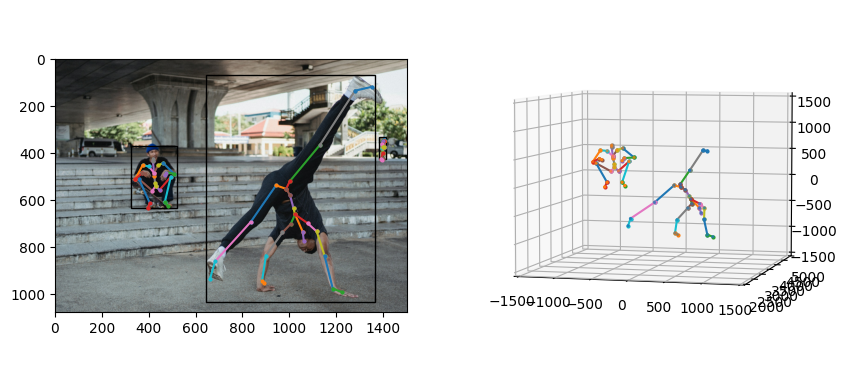

In [ ]:
joint_names = model.per_skeleton_joint_names['smpl_24'].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges['smpl_24'].numpy()
plot_results(img, pred, joint_names, joint_edges)

### Cleaning poses on floor!!!

In [ ]:
import joblib
vibe_dict = joblib.load('/content/drive/MyDrive/THESIS/data/SWDance/vibe_output/0.pkl')
vibe_dict.keys()

dict_keys(['pred_cam', 'verts', 'pose', 'betas', 'joints3d', 'bboxes', 'frame_ids', 'smpl24_joints'])

In [ ]:
def apply_xy_movement(bboxes, joints):

  # normalise bboxes between 0 & 1
  bbox_diff = np.max(bboxes, axis=0) - np.min(bboxes, axis=0)
  bbox_norm = (bboxes-np.min(bboxes, axis=0))/bbox_diff

  origin = bbox_norm[0]
  delta_bbox = bbox_norm - origin

  joints = joints.copy()
  for i, joint in enumerate(joints):
    joints[i, :, 0] = joints[i, :, 0] - delta_bbox[i, 0]
    joints[i, :, 1] = joints[i, :, 1] - delta_bbox[i, 1]

  return joints

def feet_on_the_floor(joints):

  # lowest y coordinate of feet joints (= 10 & 11)
  lowest = min(np.min(joints[:, 10, 1]), np.min(joints[:, 11, 1]))
  diff = 0 - lowest # difference with the floor..
  joints[:, :, 1] = joints[:, :, 1] + diff # only change y position to be normalized above floor...
  return joints

In [ ]:
import numpy as np
from scipy.signal import savgol_filter

j = vibe_dict['smpl24_joints']
b = vibe_dict['bboxes']

j_new = apply_xy_movement(b, j)
j_new2 = feet_on_the_floor(j_new)
j_smooth = savgol_filter(j_new2, window_length=8, polyorder=3, axis=0)

In [ ]:
kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]
plot_3d_motion('/content/feetandetc.mp4', kinematic_chain, j_smooth, title=" ", fps=25, radius=4)

data 1 shape: (482, 24, 3)
data final shape: (482, 24, 3)
ani is saved


In [ ]:
# dit moet je doen om alles te laten verplaatsen vanaf origin!!

def normalize(arr):

  diff_arr = np.max(arr, axis=0) - np.min(arr, axis=0)
  print(diff_arr)

  new_arr = (arr-np.min(arr))*2/diff_arr + -1
  return new_arr


n = normalize(vibe_dict['bboxes'])
origin = n[0]
d = n - origin

q = vibe_dict['smpl24_joints'].copy()
for i, pose in enumerate(q):
  q[i, :, 0] = q[i, :, 0] - d[i, 0]
  q[i, :, 1] = q[i, :, 1] - d[i, 1]
q.shape

NameError: ignored

In [ ]:
kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]
save_path = '/content/000000.mp4'
plot_3d_motion(save_path, kinematic_chain, q, title=" ", fps=8, radius=4)

data 1 shape: (482, 24, 3)
data final shape: (482, 24, 3)
ani is saved


In [ ]:
joints = vibe_dict['smpl24_joints']

NameError: ignored

In [ ]:
r = q.copy()
r2 = feet_on_the_floor(r)
plot_3d_motion('/content/feetonthefloor.mp4', kinematic_chain, r2, title=" ", fps=8, radius=4)

data 1 shape: (482, 24, 3)
data final shape: (482, 24, 3)
ani is saved


In [ ]:
# applying savgol filter?
from scipy.signal import savgol_filter

r2_smooth = savgol_filter(r2, window_length=8, polyorder=3, axis=0)
r2_smooth.shape

(482, 24, 3)

In [ ]:
plot_3d_motion('/content/smooth_feet.mp4', kinematic_chain, r2_smooth, title=" ", fps=8, radius=4)

data 1 shape: (482, 24, 3)
data final shape: (482, 24, 3)
ani is saved


In [ ]:
np.array_equal(r2, r2_smooth)

False

### Test yt video quality...

In [ ]:
url = 'https://youtu.be/fSHjGPWmkb8?si=dGKHHuQFkyriv3hi'
yt = YouTube(url)
# video_fps = yt.streams[0].fps
# video_file = yt.streams.first().download(output_path='/tmp', filename=f'{video_idx}.mp4')
yt.streams.first()

<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="8fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">

In [ ]:
yt.streams[0].resolution

'144p'

In [ ]:
yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()

<Stream: itag="22" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">

In [ ]:

sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

In [ ]:
import nltk

nltk.downloader.download('vader_lexicon')
sia = nltk.sentiment.vader.SentimentIntensityAnalyzer()
c = sia.polarity_scores('i love you')['compound']
0.5 <= 0.6 <= c

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

True

### The OLD DP!!

In [ ]:
VIDEO_SAVEPATH = '/content/drive/MyDrive/THESIS/data/SWDance/videos'

class DataProcessor:

  def __init__(self, data_dir, device=None):
    ''' In video_path, insert either a directory where your videos are stored,
        or otherwise, a link to a single youtube video or a youtube playlist
        link '''
    self.data_dir = data_dir
    self.videos_df = pd.read_csv(osp.join(self.data_dir, 'video_files.csv'))

    self.device = DEVICE if device is None else device

    self.whisper_model = WHISPER_MODEL
    self.glove_model = GLOVE_MODEL
    self.emotion_tokenizer = EMOTION_TOKENIZER
    self.emotion_model = EMOTION_MODEL
    self.vibe_model = VIBE_MODEL
    self.MPT = MY_MPT
    self.SMPL_layer = SMPL_LAYER
    self.nlp = NLP

    self.min_frames = 25
    self.vibe_batch_size = 450
    self.tracker_batch_size = 12
    self.yolo_img_size = 416
    self.display = False
    self.render = False
    self.bbox_scale = 1.1
    self.smooth_pose = False

  def download_yt_video(self, url, video_idx):

    if osp.isfile(f'{VIDEO_SAVEPATH}/{video_idx}.mp4'):
      print(f'yt video exists: {VIDEO_SAVEPATH}/{video_idx}.mp4')
      return f'{VIDEO_SAVEPATH}/{video_idx}.mp4', self.videos_df.loc[video_idx, ('fps')]

    yt = YouTube(url)
    stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    # stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').first()
    print(f'video resolution= {stream.resolution}')
    video_fps = stream.fps
    video_file = stream.download(output_path=f'{VIDEO_SAVEPATH}', filename=f'{video_idx}.mp4')

    if video_file is None:
      exit('Youtube url is not valid!')
    print(f'YouTube Video has been downloaded to {video_file}...')
    return video_file, video_fps

  def get_whisper_captions(self, video_file):
    video_idx = osp.basename(video_file).replace('.mp4', '')
    audio_file = osp.join('/tmp', f'{video_idx}.wav')
    caps_file = osp.join(osp.join(self.data_dir, 'caption_output'),
                           f"{video_idx}.pkl")

    if osp.isfile(audio_file):
      print(f'audio video exists: {audio_file}')
    else:
      clip = mopy.editor.VideoFileClip(video_file)
      clip.audio.write_audiofile(audio_file, codec='pcm_s16le')

    if osp.isfile(caps_file):
      print(f'caps file exists: {caps_file}')
      return joblib.load(caps_file)
    else:
      # captions = self.whisper_model.transcribe(audio_file) # normal whisper model
      captions = self.whisper_model.transcribe(audio_file, word_timestamps=False).to_dict()
      joblib.dump(captions, caps_file)

    del audio_file
    return captions

  def process_captions(self, captions, video_fps):
    # function inspired by HumanML3D github

    processed_captions = []

    for caption in captions['segments']:
      text = caption['text']
      text = self.augment_captions(text)
      doc = self.nlp(text)

      if doc == "" or doc == " ":
        # save empty as X? -> https://spacy.io/api/token#attributes
        tokens = ' /X'

      else:
        word_list, pos_list = [], []
        for token in doc:
          word = token.text
          if not word.isalpha():
            continue
          if (token.pos_ == 'NOUN' or token.pos_ == 'VERB') and (word != 'left'):
            word_list.append(token.lemma_)
          else:
            word_list.append(word)
          pos_list.append(token.pos_)
        tokens = ' '.join([f'{word_list[i]}/{pos_list[i]}' for i in range(len(word_list))])

      # timestamp (s) to frame_count
      start = caption['start']
      end = caption['end']

      caption_info = {"text": caption["text"], "tokens": tokens, "start": start, "end": end}
      processed_captions.append(caption_info)

    return processed_captions

  def augment_captions(self, caption, emotions=True, similar_words=True):

    sia = SentimentIntensityAnalyzer()
    cap_polarity = sia.polarity_scores(caption)['compound']

    if emotions:
      input_ids = self.emotion_tokenizer.encode(caption, return_tensors='pt')
      emotion_output = self.emotion_model.generate(input_ids=input_ids, max_length=20)
      emotion = [self.emotion_tokenizer.decode(ids, skip_special_tokens=True) for ids in emotion_output][0]
    else:
      emotion = ""

    if similar_words:   # TODO: only simwords for the emotion word??
      similar_words = self.glove_model.most_similar(emotion) # could premake this bc it has only 5 emotions
      similar_words = [w[0] for w in similar_words]
      for word in similar_words:
        word_polarity = sia.polarity_scores(word)['compound']
        if not cap_polarity - 0.3 <= word_polarity <= cap_polarity + 0.3:
          similar_words.remove(word)

      similar_words = " ".join(similar_words[:5])
    else:
      similar_words = ""

    return f'{caption} {emotion} {similar_words}'

  def get_vibe_poses(self, video_file):
    # inspired by VIBE github code but modified.
    # need to download VIBE in subfolder to be able to run this.

    video_idx = osp.basename(video_file).replace('.mp4', '')
    output_file = osp.join(osp.join(self.data_dir, 'vibe_output'),
                           f"{video_idx}.pkl")

    if osp.isfile(output_file):
      print(f'VIBE file exists: {output_file}')
      output_dict = joblib.load(output_file)
      return output_dict

    image_folder, num_frames, img_shape = video_to_images(video_file, return_info=True)
    print(f'Video {video_idx}, number of frames: {num_frames}')
    orig_height, orig_width = img_shape[:2]
    total_time = time.time()

    print('Tracking pose...')
    tracking_results = self.MPT(image_folder)
    for person_id in list(tracking_results.keys()):
        if tracking_results[person_id]['frames'].shape[0] < self.min_frames:
            del tracking_results[person_id]

    print(f'Running VIBE on each tracklet...')
    output_dict = {
            'pred_cam': [],
            'verts': [],
            'pose': [],
            'betas': [],
            'joints3d': [],
            'bboxes': [],
            'frame_ids': [],
        }

    for person_id in tqdm(list(tracking_results.keys()), position=0, leave=True):
        bboxes = None
        bboxes = tracking_results[person_id]['bbox']
        print(bboxes)
        frames = tracking_results[person_id]['frames']

        dataset = Inference(
            image_folder=image_folder,
            frames=frames,
            bboxes=bboxes,
            joints2d=None,
            scale=self.bbox_scale,
        )

        bboxes = dataset.bboxes
        current_frames = dataset.frames

        dataloader = DataLoader(dataset, batch_size=self.vibe_batch_size, num_workers=16)

        with torch.no_grad():
            pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d = [], [], [], [], []

            for batch in dataloader:
                batch = batch.unsqueeze(0)
                batch = batch.to(dp.device)
                batch_size, seqlen = batch.shape[:2]

                output = dp.vibe_model(batch)[-1]

                pred_cam.append(output['theta'][:, :, :3].reshape(batch_size * seqlen, -1))
                pred_verts.append(output['verts'].reshape(batch_size * seqlen, -1, 3))
                pred_pose.append(output['theta'][:,:,3:75].reshape(batch_size * seqlen, -1))
                pred_betas.append(output['theta'][:, :,75:].reshape(batch_size * seqlen, -1))
                pred_joints3d.append(output['kp_3d'].reshape(batch_size * seqlen, -1, 3))

            variables = [pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d]
            for i, var in enumerate(variables):
              variables[i] = torch.cat(var, dim=0).cpu().numpy()
            variables.append(bboxes)

            # this func doesn't work!!
            # if self.smooth_pose:
            #   print('Running VIBE smoothing on pose...')
            #   variables[1], variables[2], variables[4] = smooth_pose(variables[2], variables[3])

            del batch

        # since it's solo dance, merge all persons together directly
        for i, frame_id in enumerate(current_frames):
          if frame_id not in output_dict['frame_ids']:
            for j, key in enumerate(output_dict.keys()):
              if key == 'frame_ids':
                output_dict[key] = np.append(output_dict[key], [frame_id])
              else:
                if output_dict[key] == []:
                  output_dict[key] = [variables[j][i]]
                else:
                  output_dict[key] = np.append(output_dict[key], [variables[j][i]], axis=0)

    print('Transform pose to correct format...')
    output_dict['smpl24_joints'] = self.transform_pose_smpl24(torch.from_numpy(output_dict['pose']),
                                                       torch.from_numpy(output_dict['betas']))

    print('Post process pose and smooth...')
    output_dict['smpl24_joints_smooth'] = self.post_process_pose(output_dict['bboxes'], output_dict['smpl24_joints'])

    total_time = time.time() - total_time
    print(f'Total time: {total_time:.2f}s for {num_frames} frames.')

    print(f'Saving output results to \"{output_file}\".')
    joblib.dump(output_dict, output_file)
    shutil.rmtree(image_folder)   # deletes the images
    return output_dict

  def transform_pose_smpl24(self, pose, betas):
    # get smpl24
    verts, smpl24_joints = self.SMPL_layer(pose, th_betas=betas)
    print(verts.shape, smpl24_joints.shape)

    # flip upside down (VIBE output = upside down)
    R = transforms3d.euler.axangle2mat([1, 0, 0], -np.pi)
    smpl24_rotated = np.dot(smpl24_joints, R)

    return smpl24_rotated

  def align_captions_poses(self, captions, pose_dict, index_df, video_idx):

    print(f'Aligning poses and caps for video {video_idx}...')
    file_idx = 0 if index_df.empty else index_df['file_idx'].iloc[-1]+1
    curr_timestamp = 0

    for caption in captions:
      if caption['start'] > curr_timestamp:
        # frames with NO captions
        file_idx, index_df = self.save_pose(
            file_idx, video_idx, pose_dict, index_df,
            start=curr_timestamp,
            end=caption['start'],
            caption=False)

      # frames WITH captions
      file_idx, index_df = self.save_pose(
          file_idx, video_idx, pose_dict, index_df,
          start=caption['start'],
          end=caption['end'],
          caption=caption)
      curr_timestamp = caption['end']

    return index_df

  def fill_missing_frames(self, joints):

    consec_missing = []   # TODO: fill up with in-betweening??

    for i in range(len(joints)):
      if np.isnan(joints[i]).all():
        consec_missing += [i]
        if len(consec_missing) > 10:
          print('more than 10 are missing consecutively ', i)
        joints[i] = joints[i-1]  # fill with prev joints
      else:
        consec_missing = []

    return joints

  def save_pose(self, file_idx, video_idx, pose_dict, index_df, start, end, caption=True):
    filename = get_filename(file_idx)
    video_fps = self.videos_df.loc[video_idx, ('fps')]
    frame_ids = [i for i in range(round(start*video_fps), round(end*video_fps)+1)]
    joints = []

    for frame_id in frame_ids:
      idx = np.where(pose_dict['frame_ids'] == frame_id)[0] # first appearance
      try:
        if idx.size > 0:
          joints += [pose_dict['smpl24_joints_smooth'][idx[0]]]
        else:
          joints += [np.full([24, 3], np.nan)]

      except Exception as e:
        print(f"not working for joints idx {idx}, {type(joints)} to append {type(pose_dict['smpl24_joints_smooth'][idx[0]])} \n {e}")

    if all(np.isnan(j).all() for j in joints):
      print(f'no joints for video {video_idx} at {start} to {end}')
      return file_idx, index_df

    # remove the Nones at the beginning and end of the list
    while np.isnan(joints[-1]).all():
      del joints[-1]
    while np.isnan(joints[0]).all():
      del joints[0]

    if len(joints) < self.min_frames:
      print(f'not enough joints for video {video_idx} at {start} to {end}')
      return file_idx, index_df

    joints = self.fill_missing_frames(joints)
    joints = np.stack(joints, axis=0)

    for side in ['', 'M']: # mirror pose
      if side == 'M':
        joints = swap_left_right(joints)

      np.save(osp.join(osp.join(self.data_dir, 'joints'), f'{side}{filename}.npy'), joints)
      df_row = {'idx': file_idx,
                'video_idx': video_idx,               # which video it belongs to
                'start_frame': round(start*video_fps),
                'end_frame': round(end*video_fps),
                'start_time': start,
                'end_time': end,
                'new_name': f'{side}{filename}.npy',  # named for humanml3d
                'fps': video_fps,
                'caption': "" if not caption else caption["text"],
                'no_frames': len(joints)}
      index_df = pd.concat([index_df, pd.DataFrame([df_row])], ignore_index=True)

      if caption:
        with open(osp.join(osp.join(self.data_dir, 'texts'), f'{side}{filename}.txt'), 'w') as f:
            f.write(f'{caption["text"]}#{caption["tokens"]}#0.0#0.0\n')
      else:
        with open(osp.join(osp.join(self.data_dir, 'texts'),
                          f'{side}{filename}.txt'), 'w') as f:
              f.write(f' # /X#0.0#0.0\n')

    file_idx += 1

    return file_idx, index_df

  def post_process_pose(self, bboxes, joints):
    # first, get x,y movement from bboxes
    # normalise bboxes between 0 & 1
    bbox_diff = np.max(bboxes, axis=0) - np.min(bboxes, axis=0)
    bbox_norm = (bboxes-np.min(bboxes, axis=0))/bbox_diff

    origin = bbox_norm[0]
    delta_bbox = bbox_norm - origin

    # joints = joints.copy()
    for i, joint in enumerate(joints):
      joints[i, :, 0] = joints[i, :, 0] - delta_bbox[i, 0]
      joints[i, :, 1] = joints[i, :, 1] - delta_bbox[i, 1]

    # then, translate pose to be standing on the floor
    # lowest y coordinate of feet joints (= 10 & 11)
    lowest = min(np.min(joints[:, 10, 1]), np.min(joints[:, 11, 1]))
    diff = 0 - lowest # difference with the floor..
    joints[:, :, 1] = joints[:, :, 1] + diff # only change y position to be normalized above floor...

    # finally, smooth pose with smoothing filter
    joints = savgol_filter(joints, window_length=12, polyorder=3, axis=0)

    return joints

  def run(self):
    try:
      index_df = pd.read_csv(osp.join(self.data_dir, 'index.csv'))
    except:
      index_df = pd.DataFrame()

    for i, video in self.videos_df.iterrows():
      print(f'Processing video {i}...')

      video_file = video['video_file']
      if video['processed'] == True:
        video_fps = video['fps']
        print(f'video {i} is already processed')
        continue
      elif any(yt in video_file for yt in ["youtube", "youtu.be"]):
        try:
          video_file, video_fps = self.download_yt_video(video_file, i)
        except Exception as e:
          print(f'Could not download video {i}, {e}')
          continue

      caps = self.get_whisper_captions(video_file)
      processed_caps = self.process_captions(caps, video_fps)

      vibe_output = self.get_vibe_poses(video_file)

      index_df = self.align_captions_poses(processed_caps, vibe_output, index_df, i)
      self.videos_df.loc[i, ('processed')] = True
      self.videos_df.loc[i, ('fps')] = video_fps

    index_df.to_csv(osp.join(self.data_dir, 'index.csv'), index=False)
    self.videos_df.to_csv(osp.join(self.data_dir,'video_files.csv'), index=False)

    return index_df